In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor

import os
from data import processing_data
from settings import BASE_DIR

# Loading our dataset

data_path = os.path.join(BASE_DIR, "dataset", "train.csv")
df = pd.read_csv(data_path)
df.head()

,genres,rating,no_of_votes,meta_score,release_date,gross,budget,countries,log_budget,log_no_of_votes,log_gross,log_gross_bin
0,"Period Drama, Biography, Drama, History, Music...",7.2,556,64.812903,2025.0,11625735.0,26000000.0,Russia,17.073607,6.322565,16.268732,2
1,"Caper, Film Noir, Action, Crime, Drama",8.1,37000,89.000000,1949.0,5534.0,1300000.0,United States,14.077876,10.518700,8.618847,0
2,"Classical Western, Drama, Romance, Western",7.7,27000,64.812903,1946.0,15293.0,2000000.0,United States,14.508658,10.203629,9.635216,0
3,"Dark Comedy, Comedy, Drama, Sport",6.8,92000,64.000000,2012.0,6985158.0,12000000.0,"United States, Canada",16.300417,11.429555,15.759298,1
4,"Coming-of-Age, Psychological Horror, Drama, Ho...",5.8,34000,86.000000,2024.0,5396508.0,26000000.0,"United States, United Kingdom",17.073607,10.434145,15.501263,1


| Siêu tham số           | Ý nghĩa                                                                 | Giá trị phổ biến / Mặc định       | Ảnh hưởng đến mô hình                                                        |
|------------------------|------------------------------------------------------------------------|-----------------------------------|--------------------------------------------------------------------------------|
| `n_estimators`         | Số lượng cây trong rừng                                                | `[50, 100, 200, 300]` (mặc định: 100) | Tăng số lượng cây giúp mô hình ổn định hơn nhưng huấn luyện lâu hơn         |
| `max_depth`            | Độ sâu tối đa của cây                                                  | `[None, 5, 10, 15]`               | Giới hạn độ sâu tránh overfitting; `None` cho phép cây phát triển tối đa    |
| `min_samples_split`    | Số mẫu tối thiểu để chia một node                                      | `[2, 5, 10]`                      | Giá trị lớn làm cây bớt phức tạp, tránh chia nhỏ quá mức                     |
| `min_samples_leaf`     | Số mẫu tối thiểu tại một node lá                                       | `[1, 3, 5]`                       | Tăng giá trị giúp cây tổng quát hơn, giảm overfitting                        |
| `max_features`         | Số lượng đặc trưng được xét tại mỗi lần chia node                      | `['sqrt', 'log2', None]`         | Tăng tính ngẫu nhiên, giúp đa dạng hóa cây và giảm overfitting               |
| `bootstrap`            | Có sử dụng lấy mẫu có hoàn lại không                                   | `[True, False]`                  | `True` giúp đa dạng hóa cây (giảm overfitting), `False` dùng toàn bộ dữ liệu |
| `criterion`            | Hàm mất mát để đánh giá chất lượng node                               | `['squared_error', 'absolute_error']` | `squared_error` nhạy với outlier; `absolute_error` bền vững hơn với outlier  |
| `max_leaf_nodes`       | Số lượng node lá tối đa (giới hạn cấu trúc cây)                        | `None` hoặc số nguyên dương       | Giới hạn này giúp kiểm soát độ phức tạp mô hình                              |
| `n_jobs`               | Số luồng CPU sử dụng để train song song                                | `-1` (tất cả CPU)                | Tăng tốc độ huấn luyện mô hình                                               |
| `random_state`         | Hạt giống ngẫu nhiên cho reproducibility                               | `42`, hoặc số bất kỳ             | Giúp kết quả có thể lặp lại khi huấn luyện nhiều lần                         |


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from evaluation import visualize_results
from save import save_model

param_grid = {
    'n_estimators': [200,300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],                    # Tăng lên để tránh overfitting ở lá rất nhỏ
    'max_features': ['sqrt', 'log2'],             # Số lượng feature được chọn ngẫu nhiên khi split
    'bootstrap': [True, False]                         # False đôi khi giúp giảm bias nhưng tăng variance
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    features = ['log_no_of_votes', 'log_budget',
                'log_genre_stat_feature','log_country_stat_feature','rating']

    target = 'log_gross'


    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest",directory="best_models")

    base_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    
    # save_model(model=best_model, model_name="random_forest",fold=fold+1,directory="best_models")
    
    print(" Best hyperparameters:", grid_search.best_params_)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )



 Fold 1


TypeError: processing_data() got an unexpected keyword argument 'directory'


 Fold 1
✅ Scaler saved to: H:\python\best_models\random_forest\fold_1\scaler.pkl


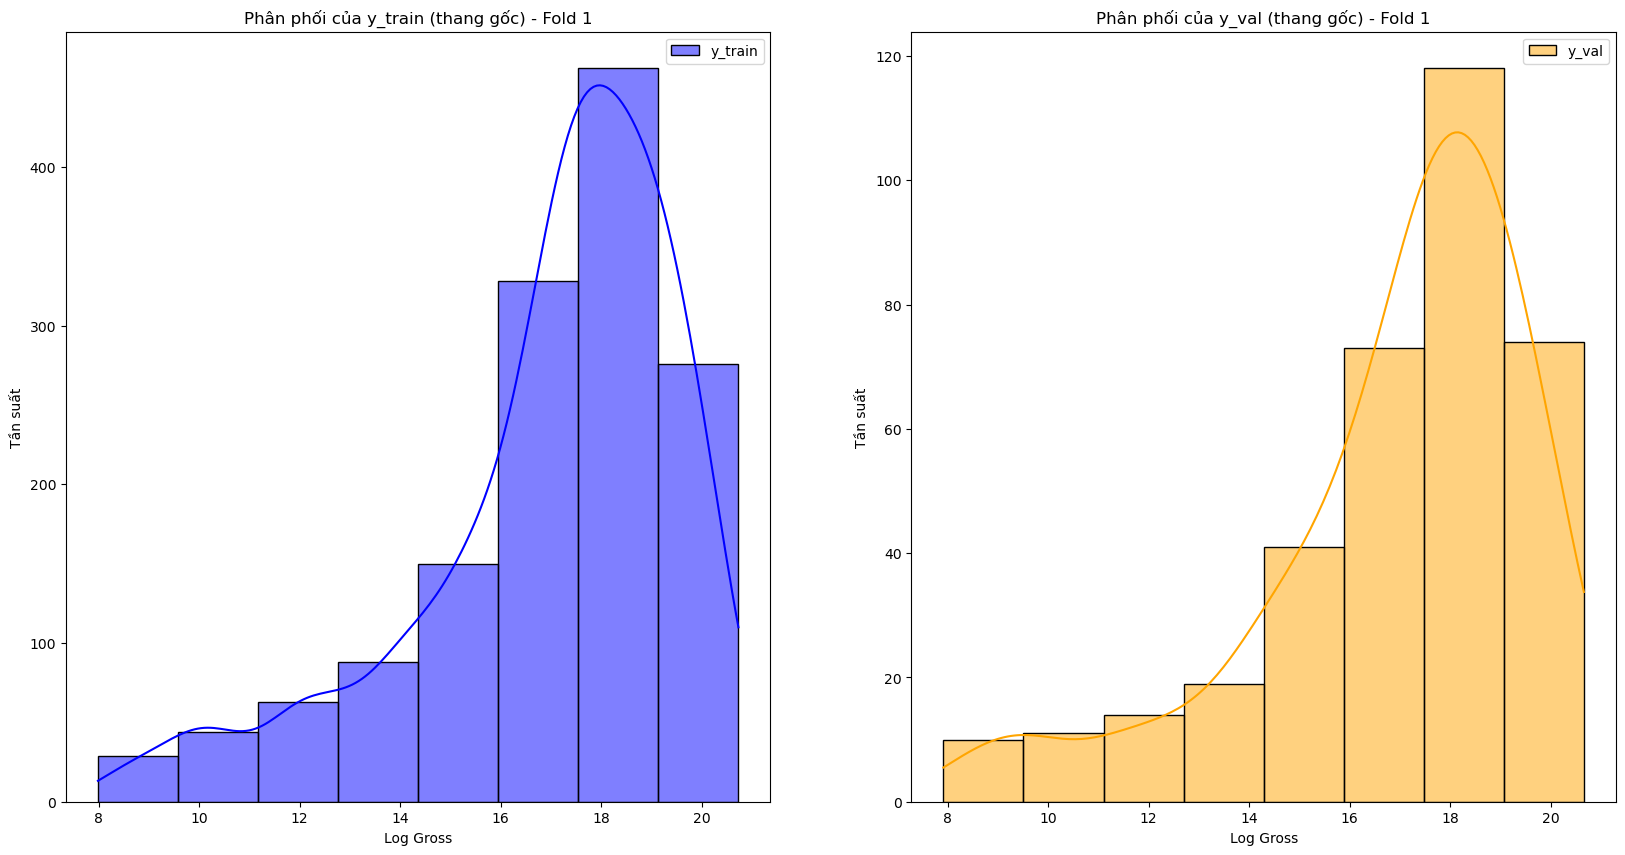

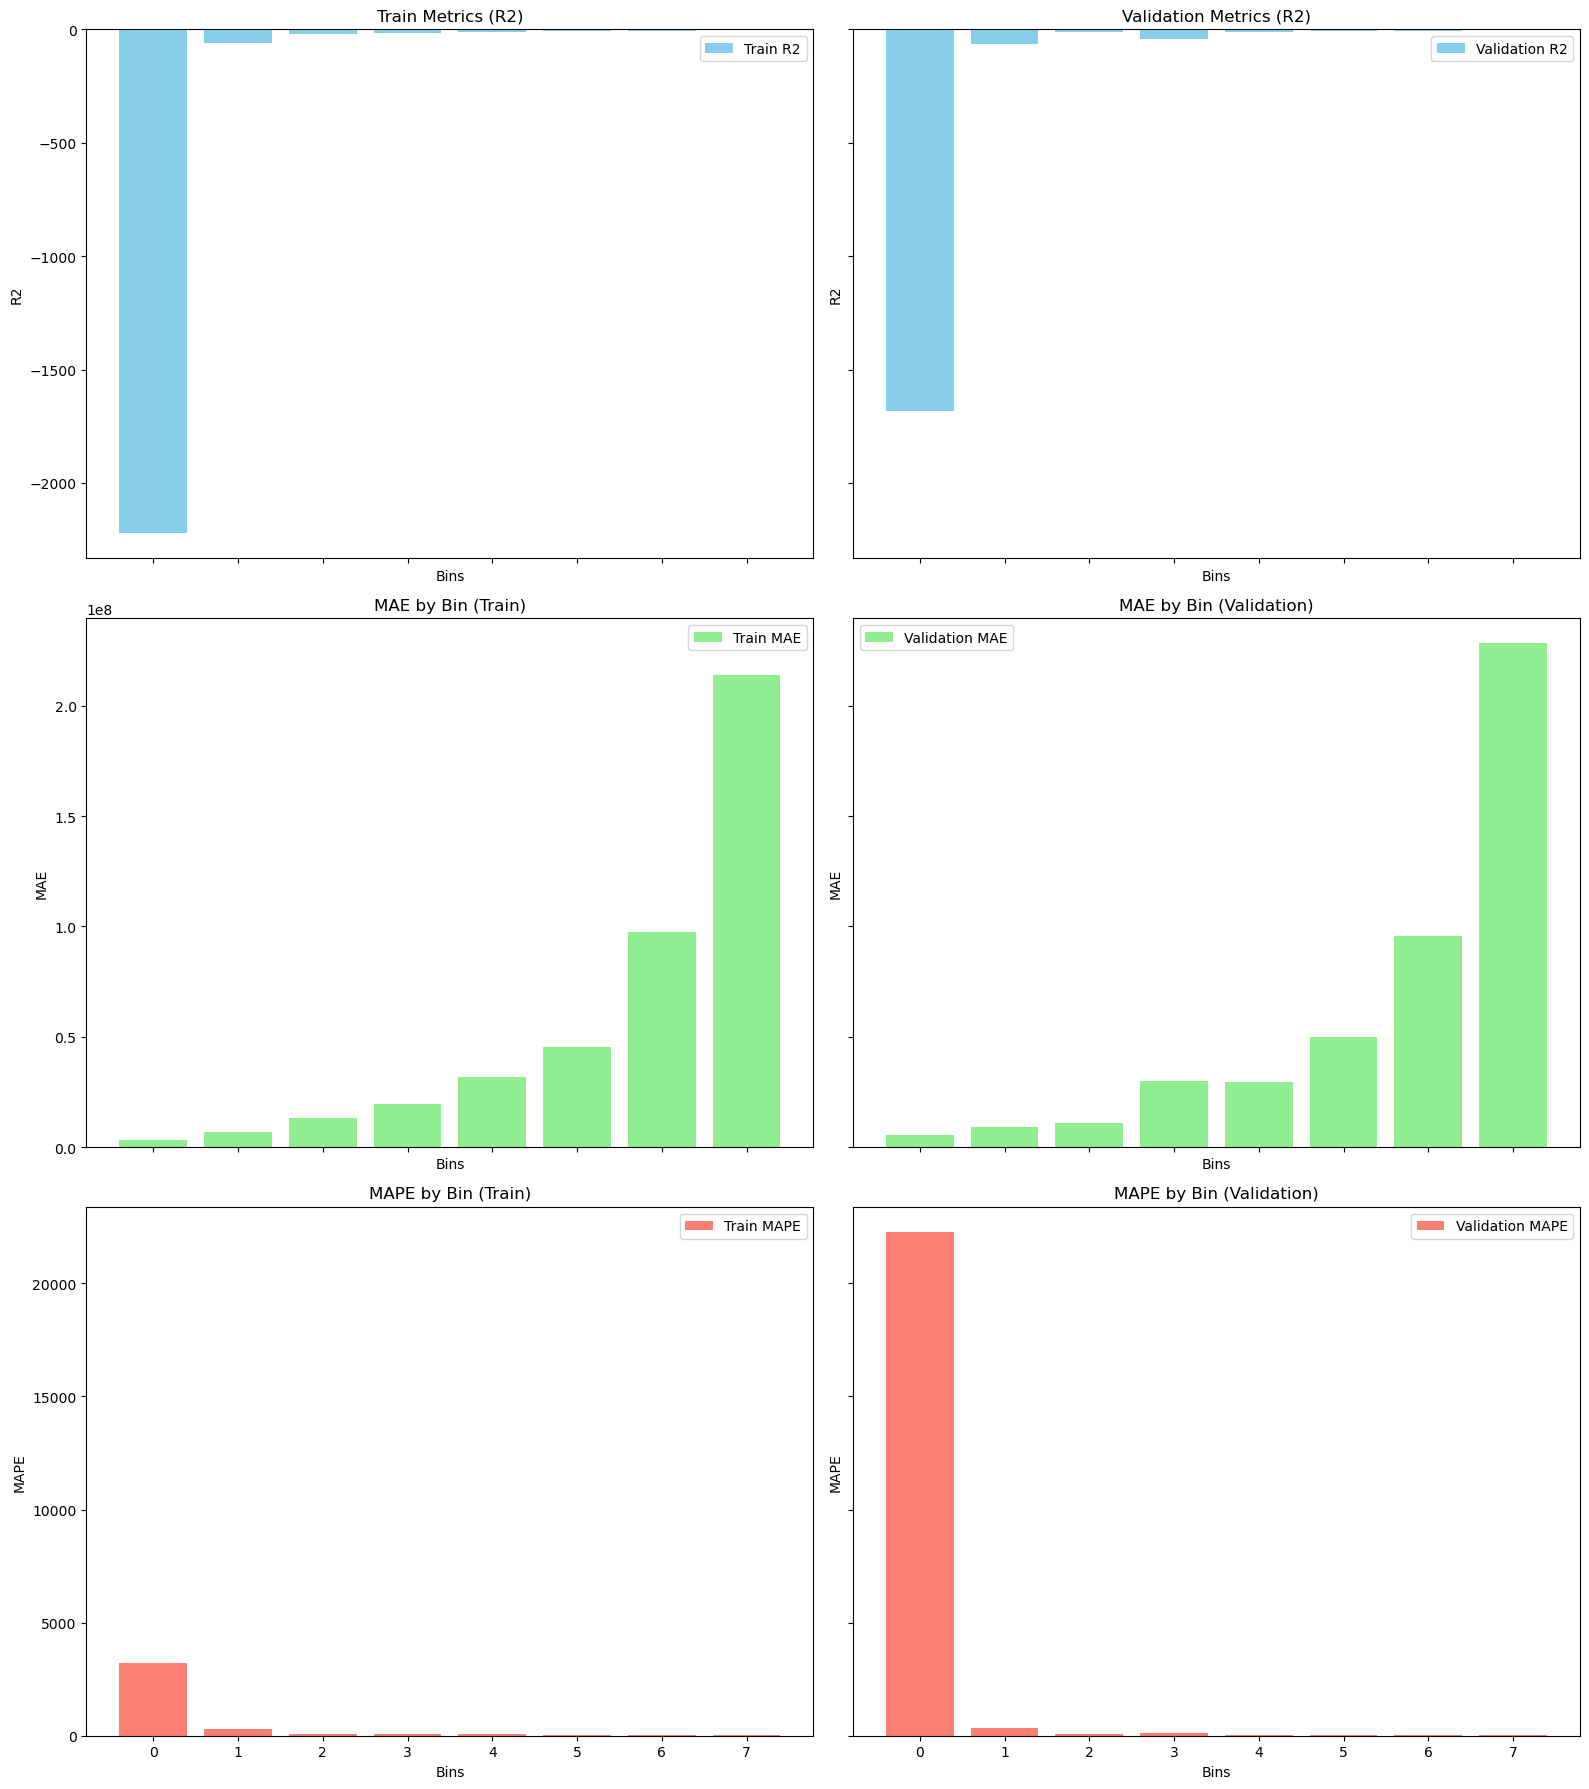

   Bin           R2           MAE         MAPE
0    0 -2221.440495  3.330011e+06  3225.032484
1    1   -61.338031  6.941259e+06   283.206115
2    2   -22.549719  1.321704e+07    95.537916
3    3   -16.754114  1.948173e+07    62.434612
4    4   -13.788597  3.161879e+07    55.113797
5    5    -6.383017  4.534102e+07    40.788108
6    6    -6.431840  9.756821e+07    45.069686
7    7    -0.807615  2.139157e+08    39.720519
   Bin           R2           MAE          MAPE
0    0 -1682.838957  5.500458e+06  22274.478113
1    1   -63.165157  9.120849e+06    349.622633
2    2   -11.212195  1.093170e+07     81.152915
3    3   -44.280413  3.015491e+07     99.662919
4    4   -10.811402  2.955547e+07     50.034283
5    5    -8.234716  5.000522e+07     46.836501
6    6    -8.886166  9.581898e+07     45.498936
7    7    -0.946162  2.284388e+08     42.215129

 Fold 2
✅ Scaler saved to: H:\python\best_models\random_forest\fold_2\scaler.pkl


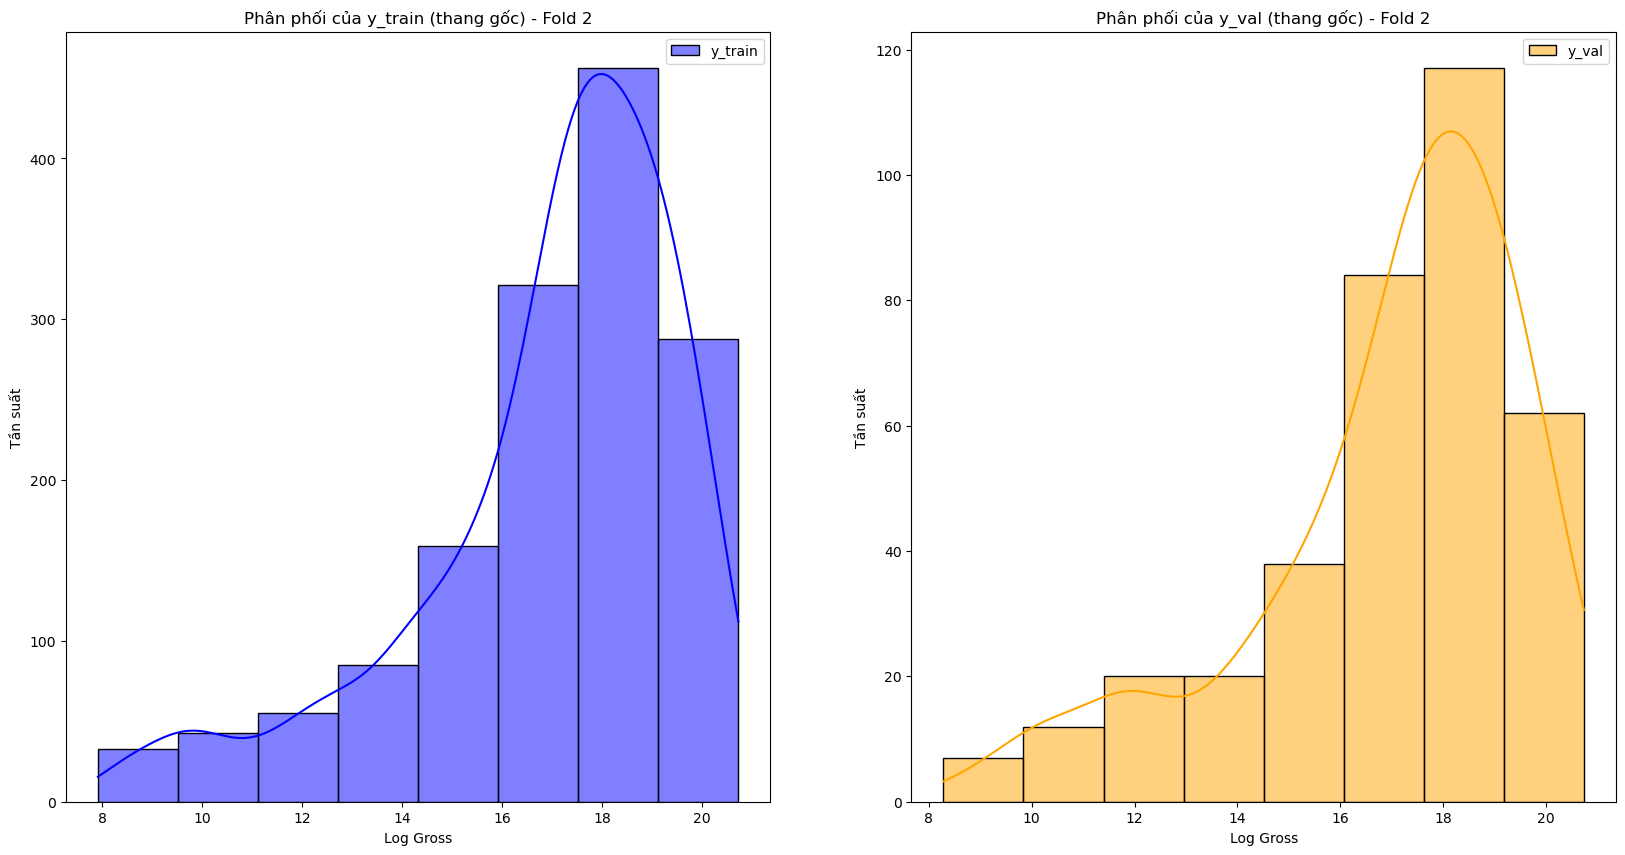

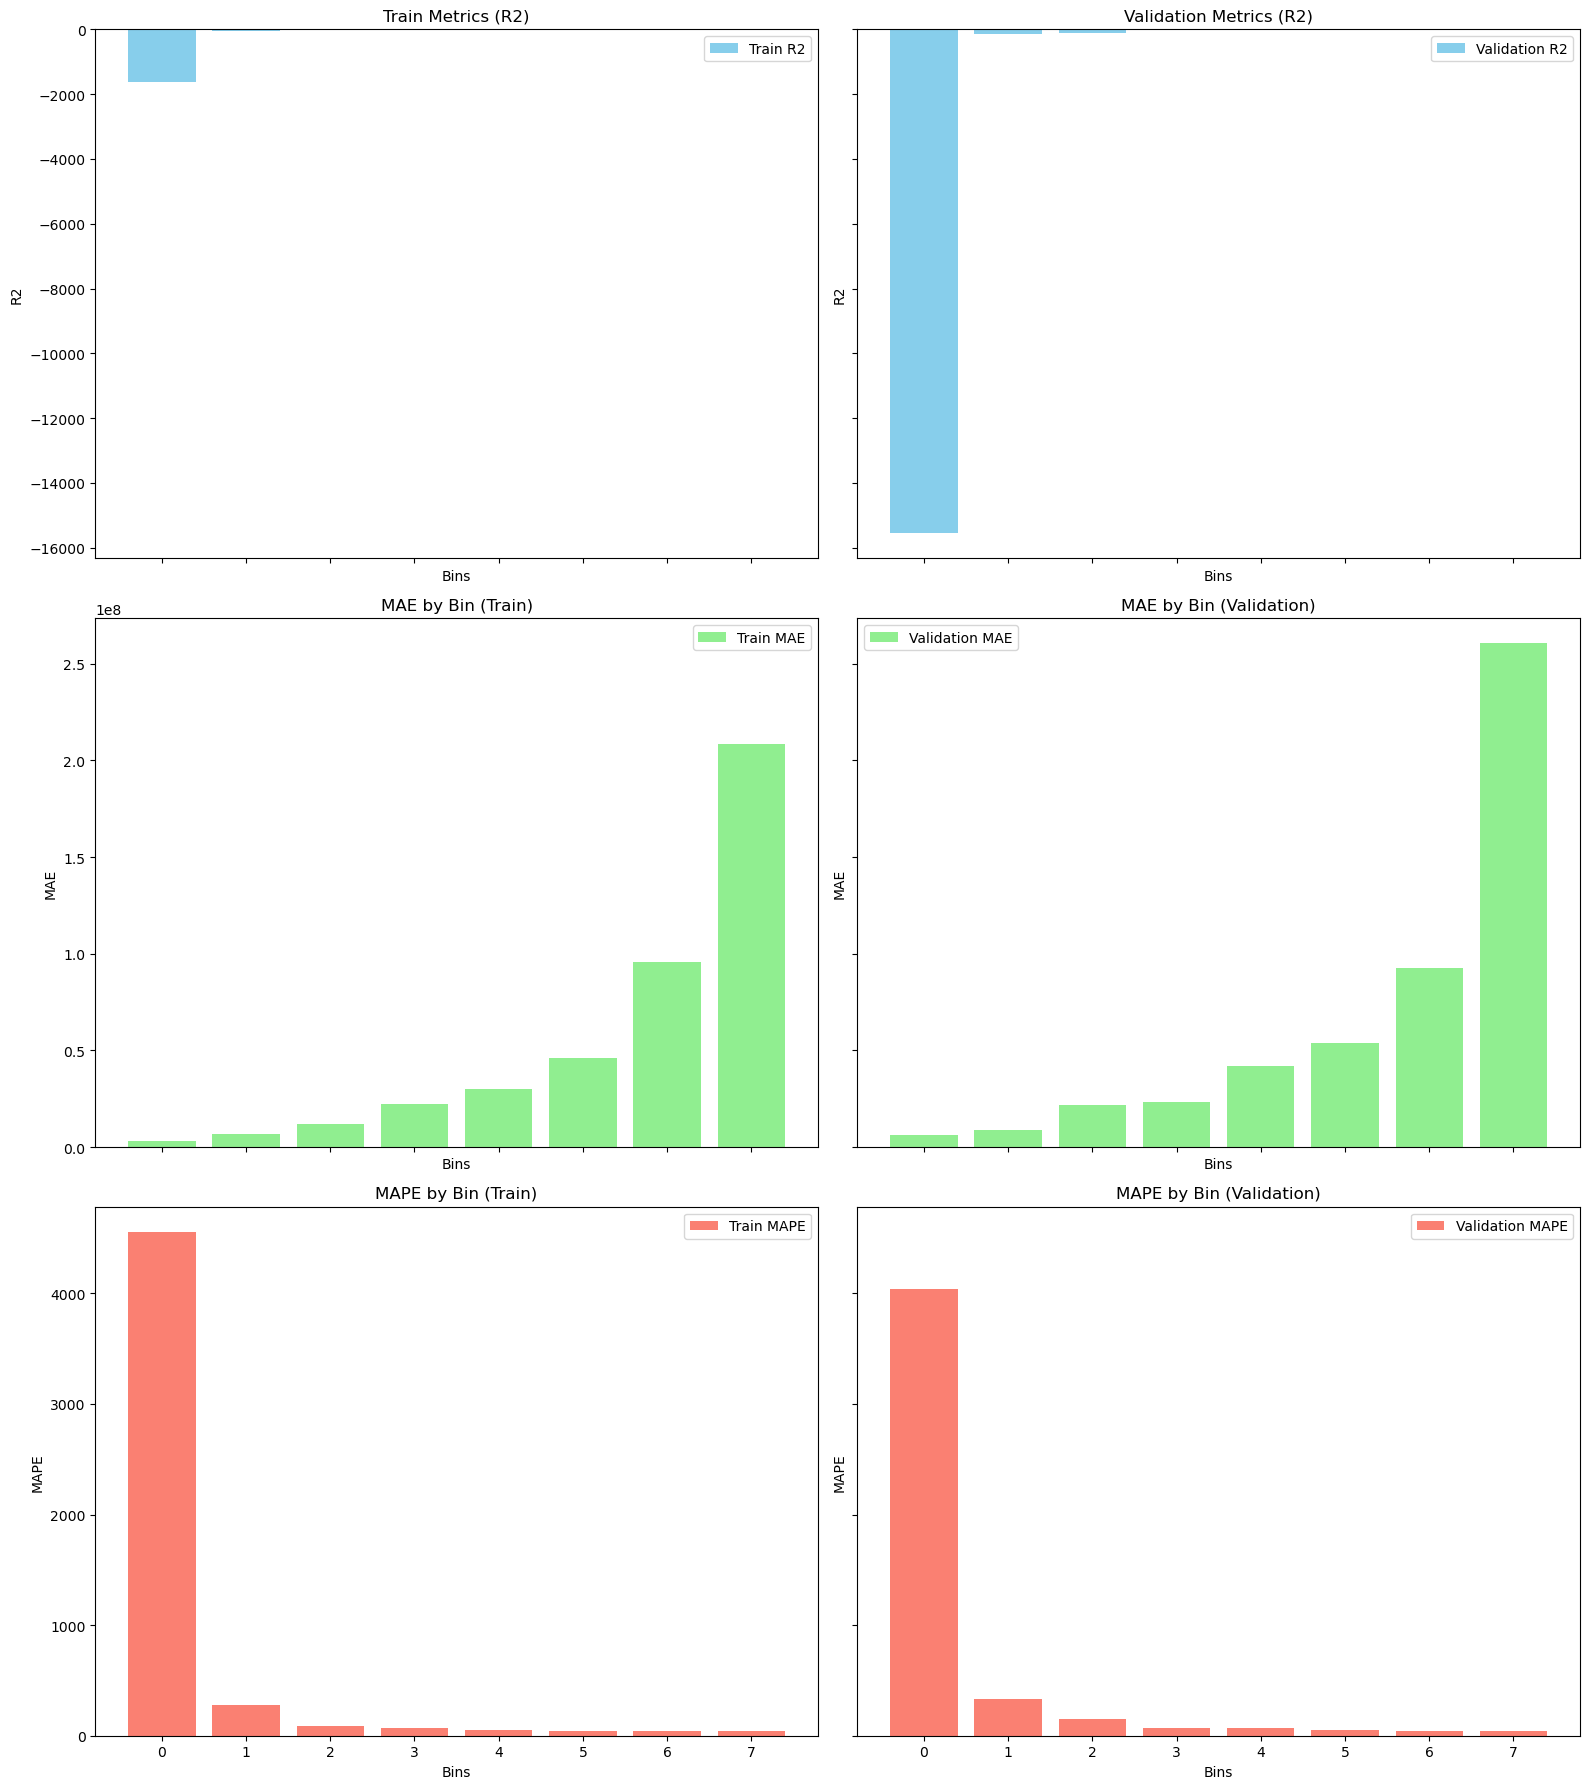

   Bin           R2           MAE         MAPE
0    0 -1610.328169  3.082529e+06  4555.757936
1    1   -57.517819  6.645461e+06   277.037341
2    2   -12.441696  1.185048e+07    84.139598
3    3   -23.602130  2.211235e+07    72.089764
4    4   -11.696578  3.008866e+07    51.971945
5    5    -7.098914  4.591034e+07    41.915663
6    6    -6.957686  9.555689e+07    43.785112
7    7    -0.781195  2.085671e+08    39.004272
   Bin            R2           MAE         MAPE
0    0 -15547.617557  6.087844e+06  4040.448589
1    1   -139.336289  9.005896e+06   332.496640
2    2   -123.084020  2.149050e+07   152.059403
3    3    -23.629523  2.309916e+07    70.550225
4    4    -29.900350  4.197884e+07    72.571280
5    5     -6.477477  5.376728e+07    48.229321
6    6     -5.633481  9.243265e+07    45.893394
7    7     -1.112063  2.605743e+08    46.142305

 Fold 3
✅ Scaler saved to: H:\python\best_models\random_forest\fold_3\scaler.pkl


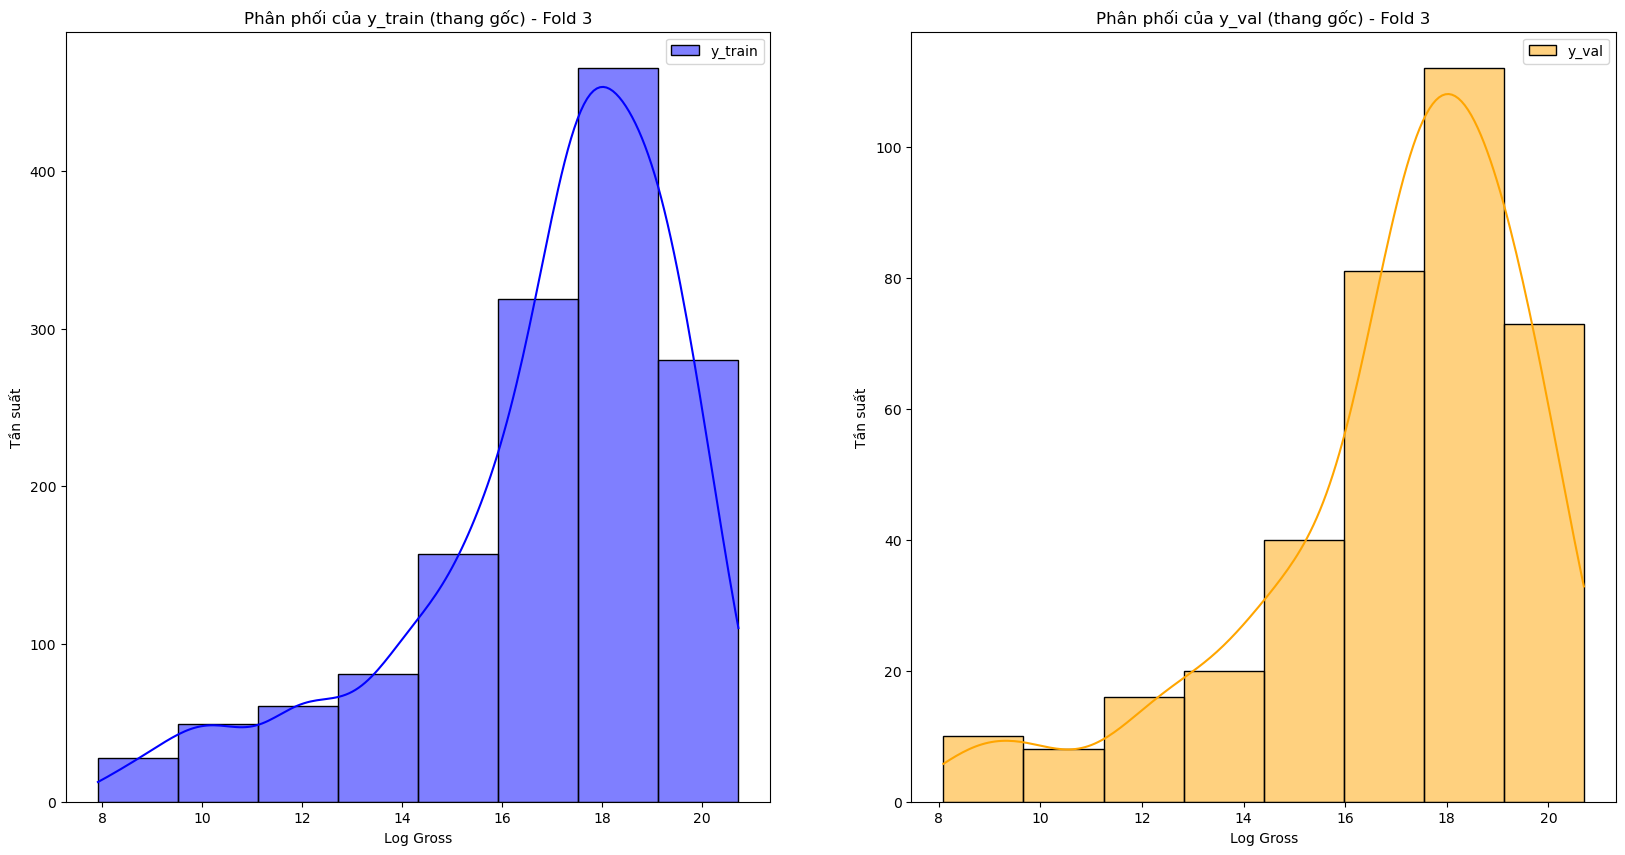

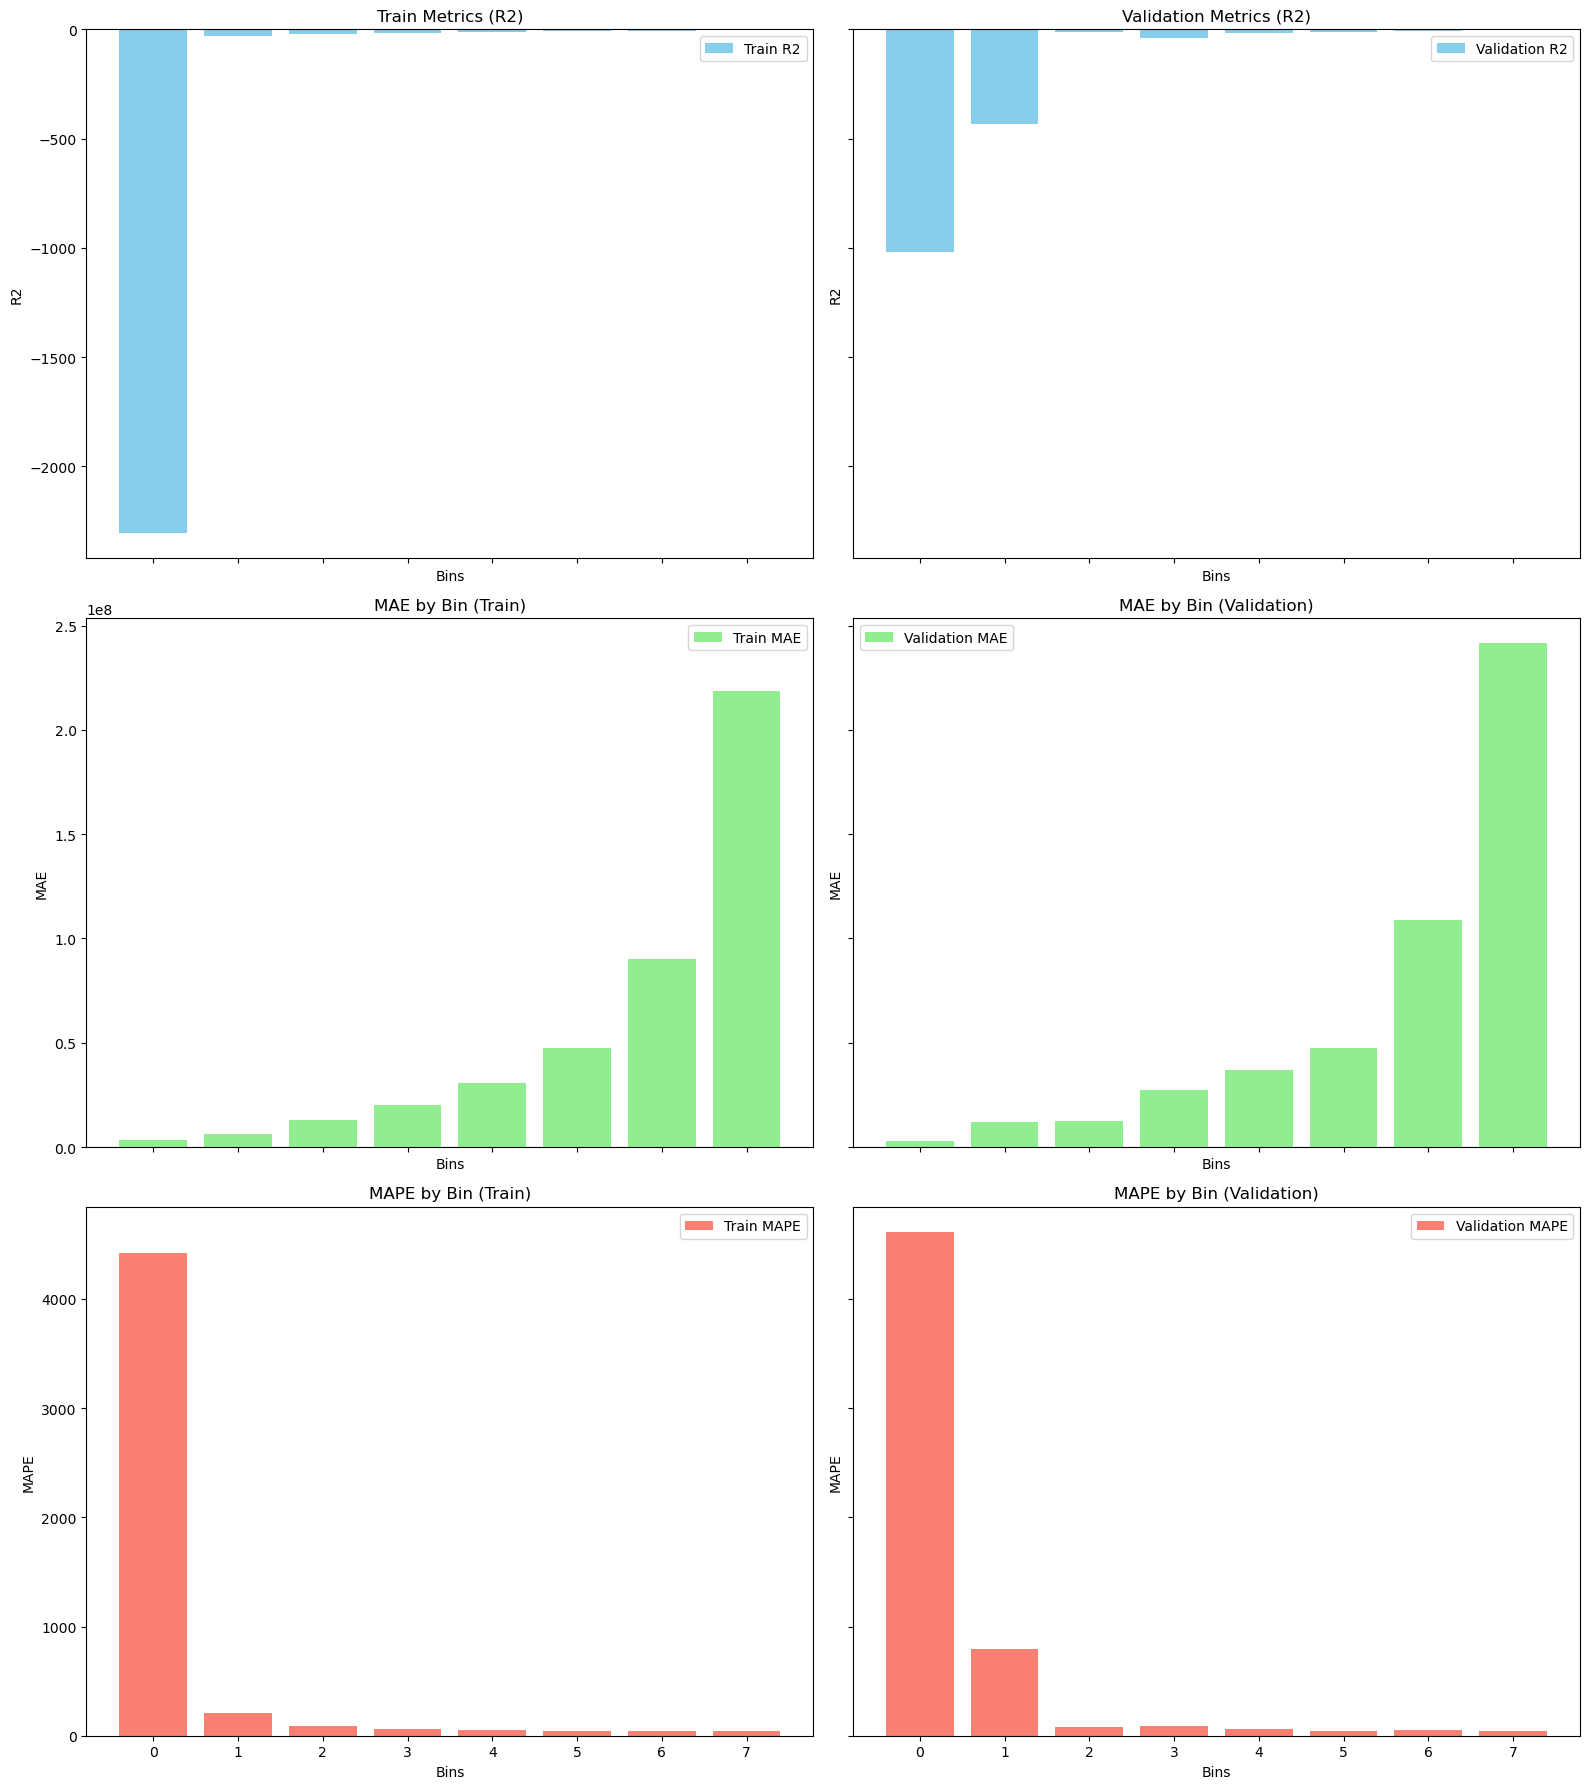

   Bin           R2           MAE         MAPE
0    0 -2305.240325  3.526424e+06  4416.616440
1    1   -32.459612  6.135975e+06   211.927759
2    2   -20.615252  1.277271e+07    92.705149
3    3   -17.608962  2.010503e+07    64.799125
4    4   -12.915621  3.052518e+07    53.283284
5    5    -6.098550  4.723479e+07    43.227341
6    6    -6.440369  9.026642e+07    42.389424
7    7    -0.842566  2.185718e+08    41.390449
   Bin           R2           MAE         MAPE
0    0 -1019.892100  2.812164e+06  4613.204274
1    1  -432.096508  1.210634e+07   798.500965
2    2   -14.057297  1.251747e+07    83.727583
3    3   -38.533212  2.719300e+07    85.576000
4    4   -17.044277  3.669485e+07    61.443826
5    5   -11.227400  4.752521e+07    42.876331
6    6    -7.184233  1.089375e+08    49.157360
7    7    -1.194962  2.415357e+08    41.568605

 Fold 4
✅ Scaler saved to: H:\python\best_models\random_forest\fold_4\scaler.pkl


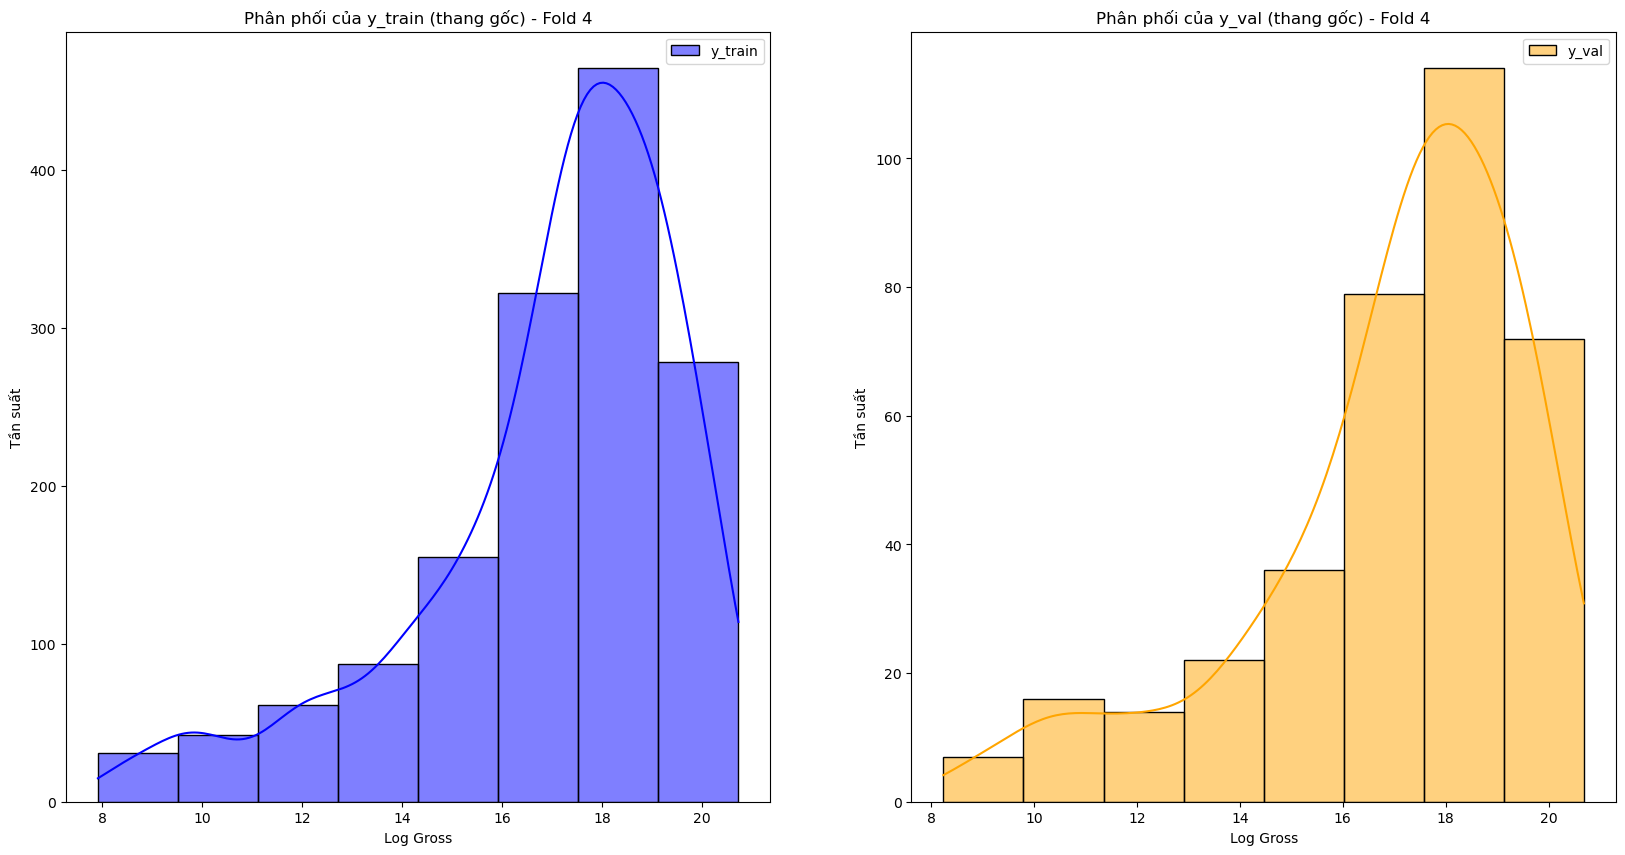

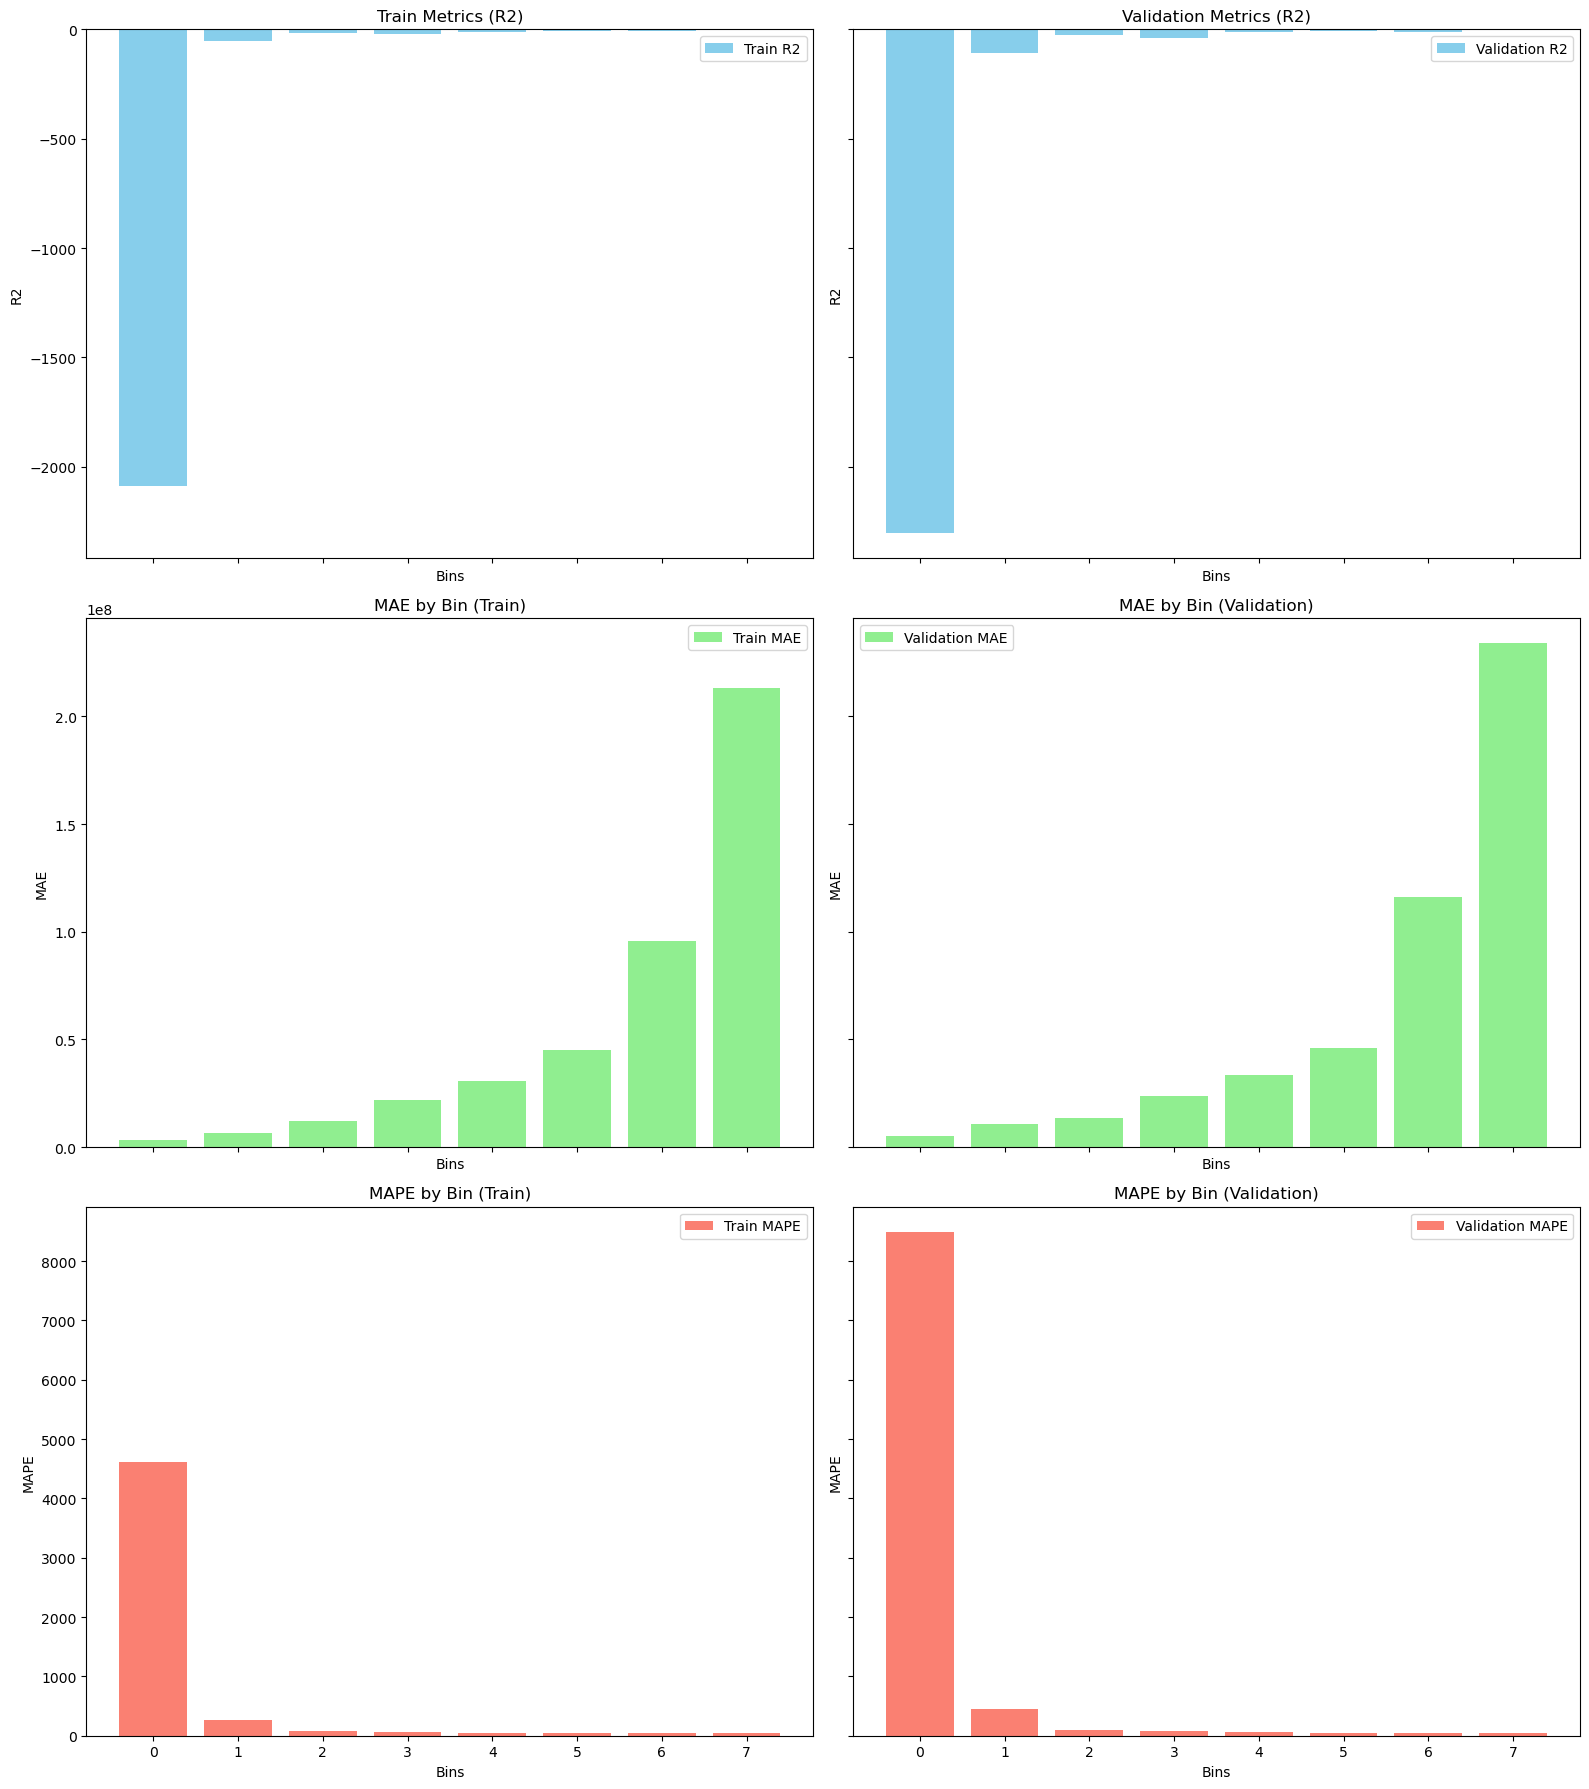

   Bin           R2           MAE         MAPE
0    0 -2085.801582  3.402571e+06  4619.374778
1    1   -51.642061  6.506732e+06   269.684126
2    2   -16.871480  1.231103e+07    86.000926
3    3   -20.238320  2.177826e+07    68.757931
4    4   -12.026472  3.046555e+07    52.519257
5    5    -6.373815  4.522709e+07    41.129922
6    6    -6.700272  9.586551e+07    44.655798
7    7    -0.756267  2.131789e+08    38.925861
   Bin           R2           MAE         MAPE
0    0 -2302.805320  4.909537e+06  8491.182919
1    1  -107.529965  1.081940e+07   451.944616
2    2   -24.392660  1.367102e+07   103.295255
3    3   -41.220754  2.390597e+07    80.715360
4    4   -13.760237  3.325021e+07    58.955071
5    5    -8.075735  4.587142e+07    42.952791
6    6   -10.019576  1.161690e+08    53.847935
7    7    -1.283392  2.340063e+08    47.842537

 Fold 5
✅ Scaler saved to: H:\python\best_models\random_forest\fold_5\scaler.pkl


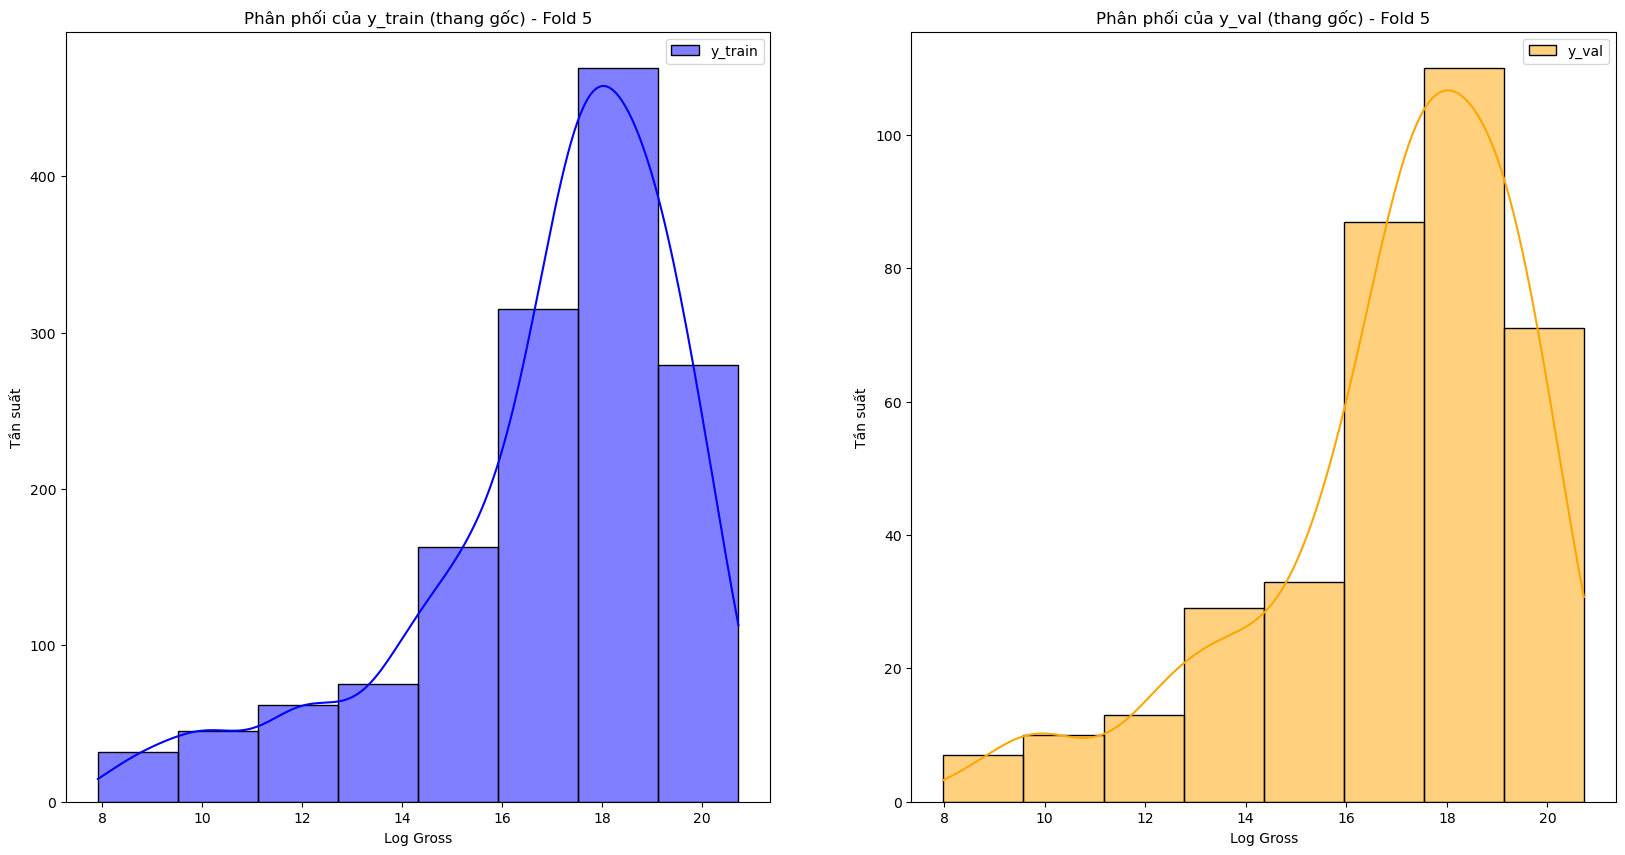

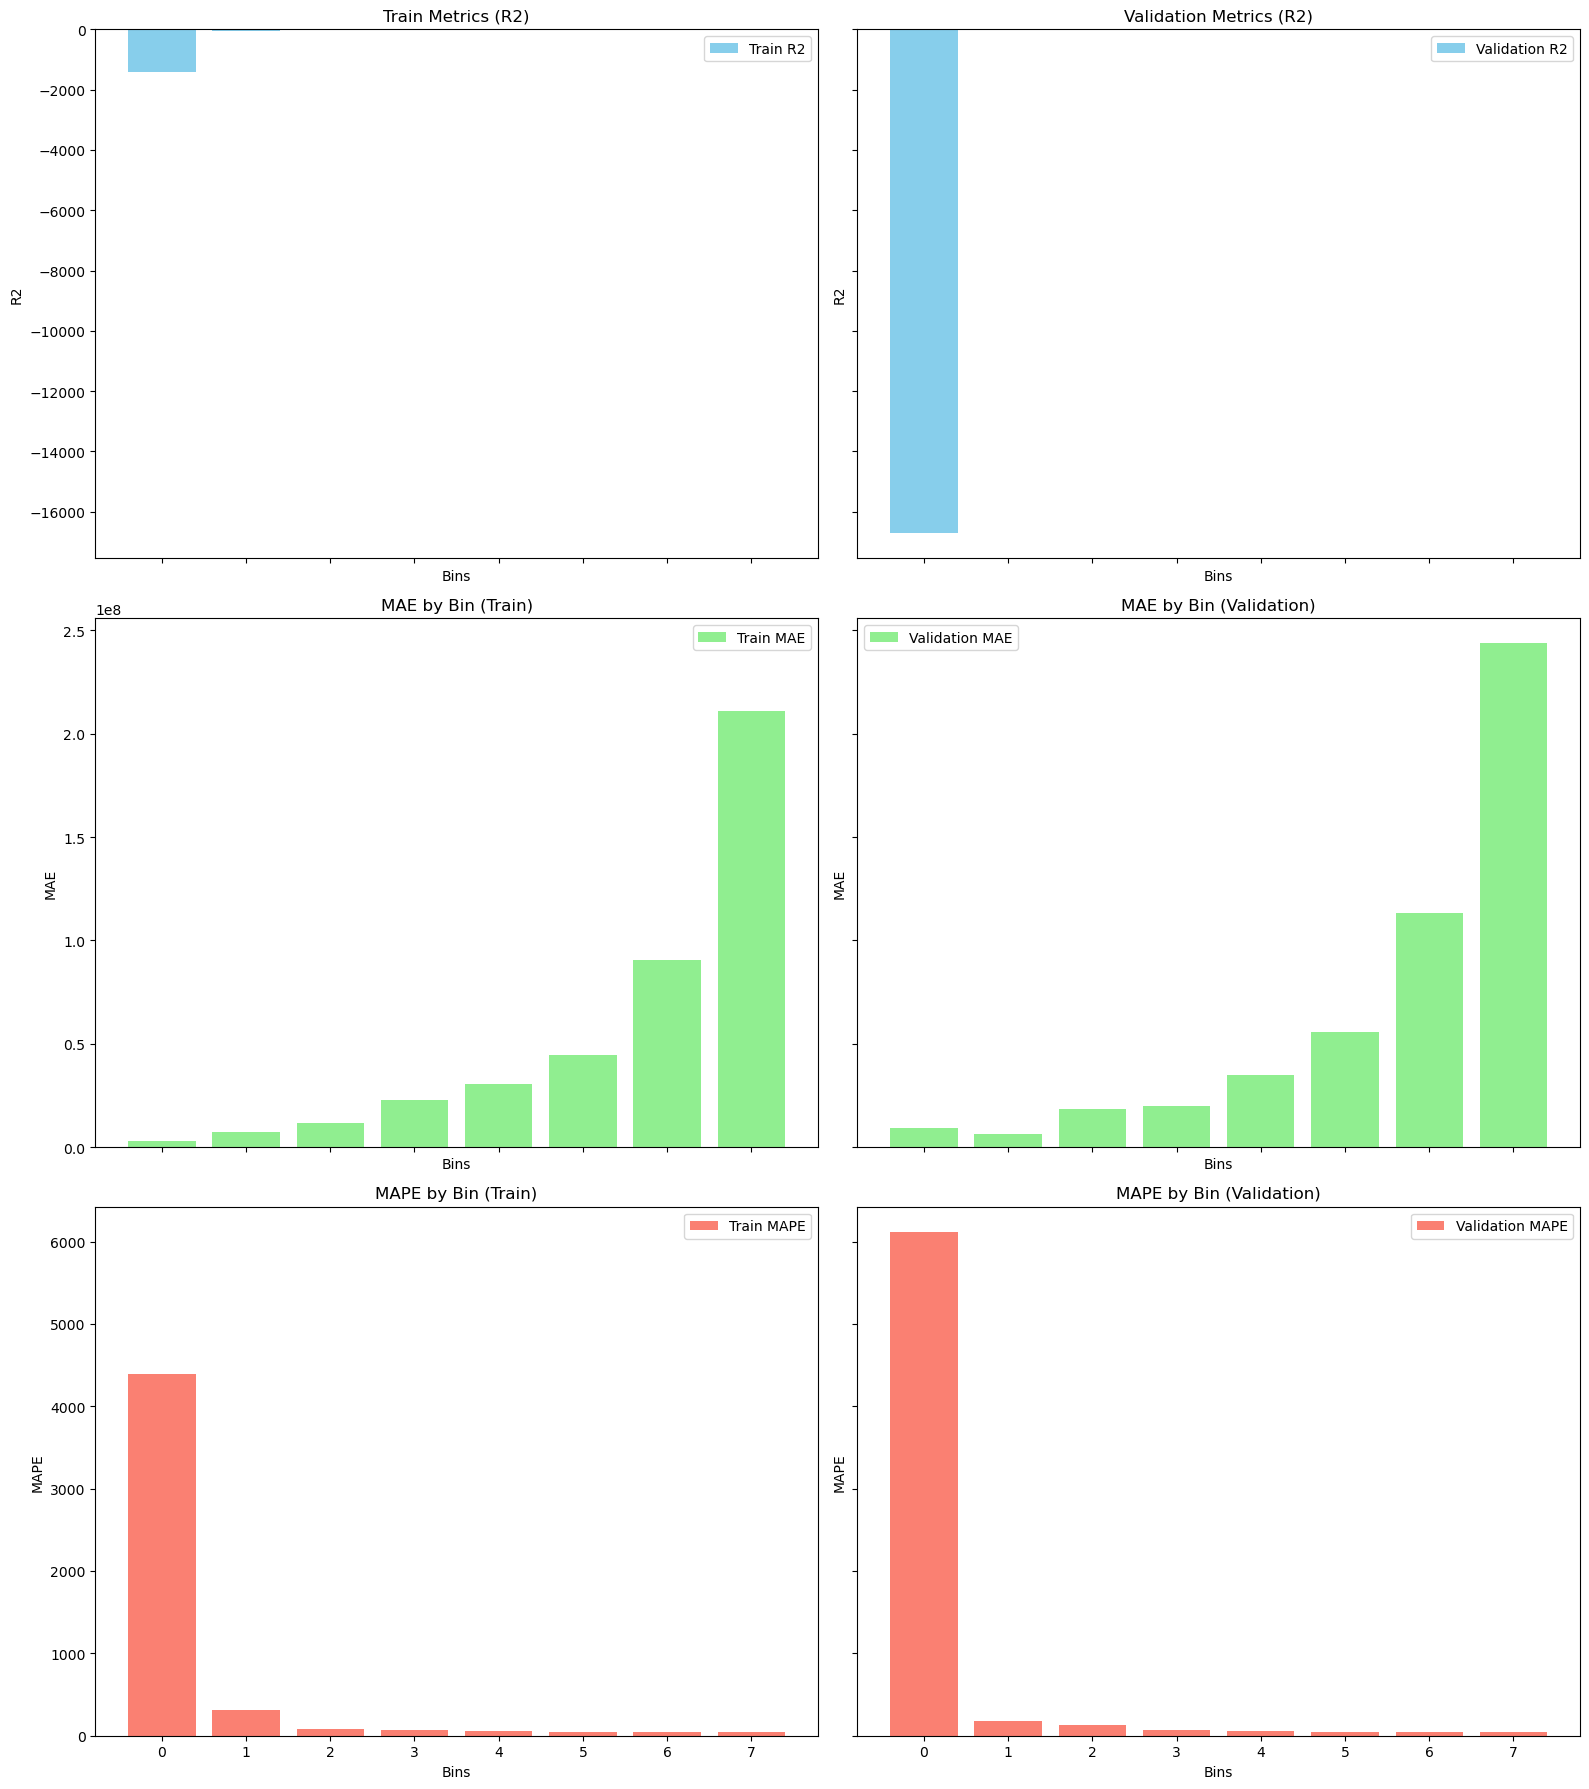

   Bin           R2           MAE         MAPE
0    0 -1426.974217  2.859828e+06  4394.833150
1    1   -68.139268  7.218146e+06   307.679627
2    2   -17.341155  1.182939e+07    84.772846
3    3   -21.301140  2.252785e+07    72.151678
4    4   -12.487820  3.041000e+07    52.229773
5    5    -6.350147  4.441886e+07    40.825867
6    6    -5.776688  9.058843e+07    42.556471
7    7    -0.659805  2.108085e+08    39.568664
   Bin            R2           MAE         MAPE
0    0 -16709.938568  9.336157e+06  6116.144433
1    1    -34.263216  6.367348e+06   179.387600
2    2    -34.975398  1.825115e+07   130.753807
3    3    -17.344349  1.992029e+07    64.569159
4    4    -19.049210  3.504454e+07    62.732821
5    5     -8.566591  5.580472e+07    49.404659
6    6    -11.755359  1.131169e+08    50.117562
7    7     -1.631664  2.438193e+08    46.374318


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from evaluation import visualize_results
from settings import FEATURES, TARGET
import matplotlib.pyplot as plt

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=FEATURES, target=TARGET, model_name="random_forest")

    best_model = RandomForestRegressor(random_state=42, bootstrap=True, min_samples_leaf=10, min_samples_split=5, n_estimators=200, max_depth=10, max_features="sqrt")
    best_model.fit(X_train, y_train)

    

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    df_train_processed = pd.DataFrame(X_train, columns=FEATURES)
    df_train_processed[TARGET] = y_train


    fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharex=True, sharey='row')  # 3 rows (R2, MAE, MAPE), 2 columns (Train, Validation)

    # Gọi visualize_results cho tập Train và vẽ vào cột đầu tiên (Train)
    df_test_result = visualize_results(df_train, y_true=y_train, y_pred=train_preds, calculate_real_target=True, dataset_label="Train", axes=axes[:, 0])

    # Gọi visualize_results cho tập Validation và vẽ vào cột thứ hai (Validation)
    df_val_result = visualize_results(df_val, y_true=y_val, y_pred=val_preds, calculate_real_target=True, dataset_label="Validation", axes=axes[:, 1])

    # Cài đặt tiêu đề và hiển thị
    axes[0, 0].set_title("Train Metrics (R2)")  # Tiêu đề cho R2 Train
    axes[0, 1].set_title("Validation Metrics (R2)")  # Tiêu đề cho R2 Validation

    plt.tight_layout()
    plt.show()
    print(df_test_result)
    print(df_val_result)


#### Thư viện Optuna


Fold 1
 Best hyperparameters: {'n_estimators': 219, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.490172278626588
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8489
MAE: 34,068,352.0442
MAPE: 1.22%
Test Metrics
R2 score: 0.6017
MAE: 62,668,626.7987
MAPE: 10.25%


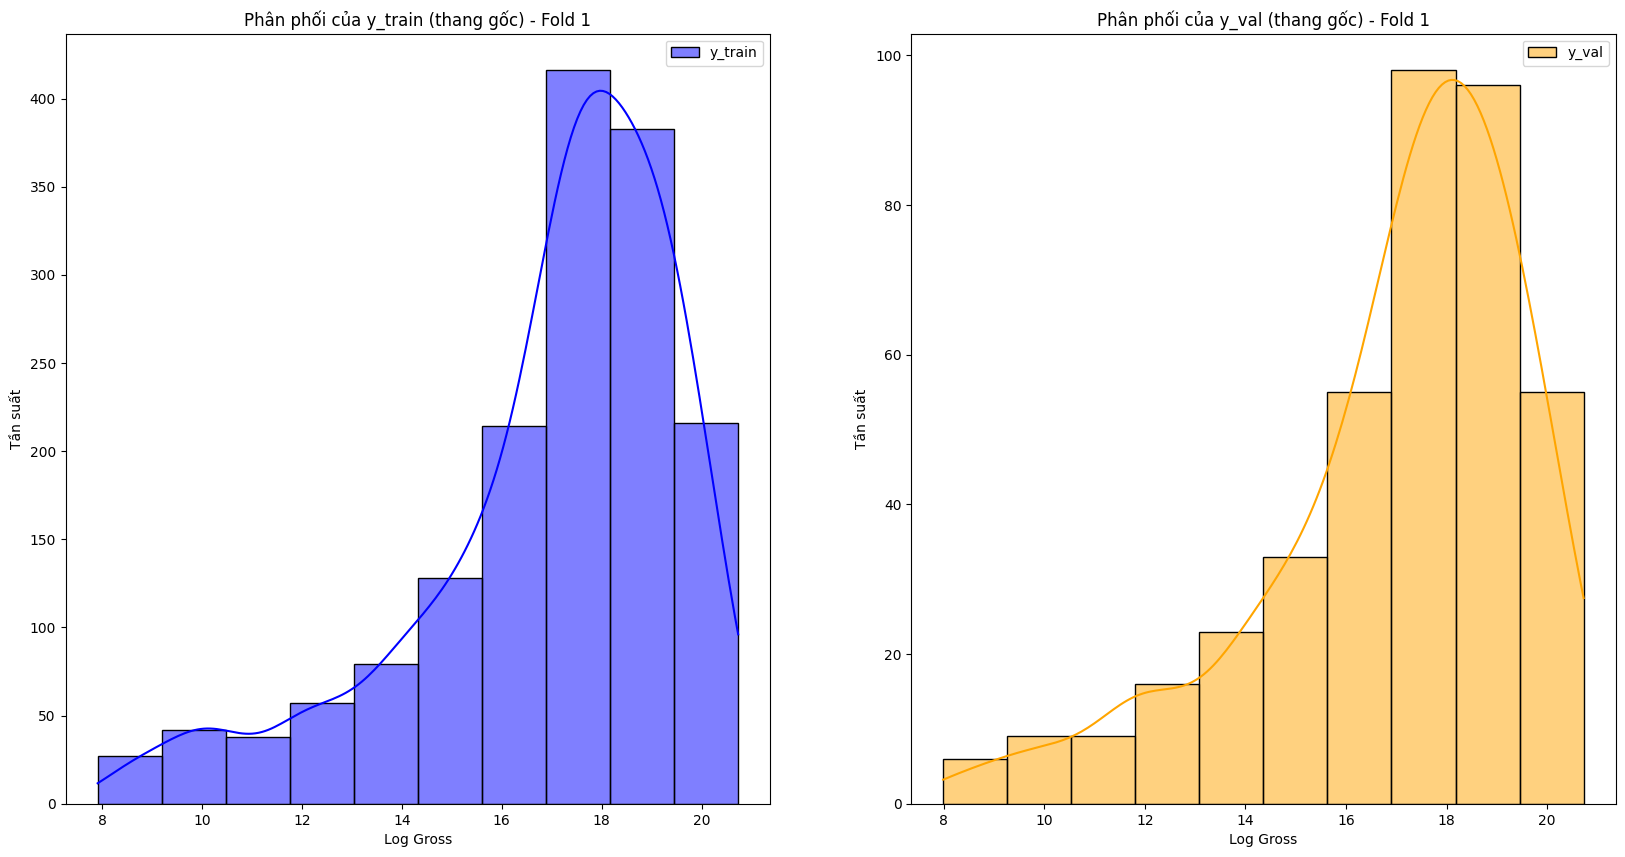

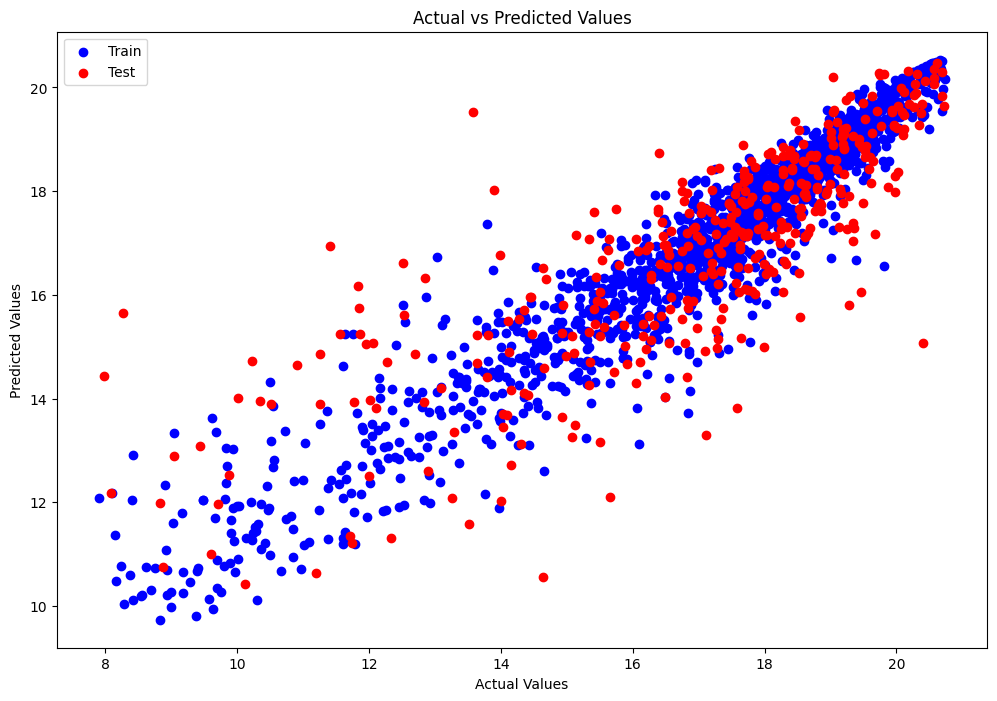

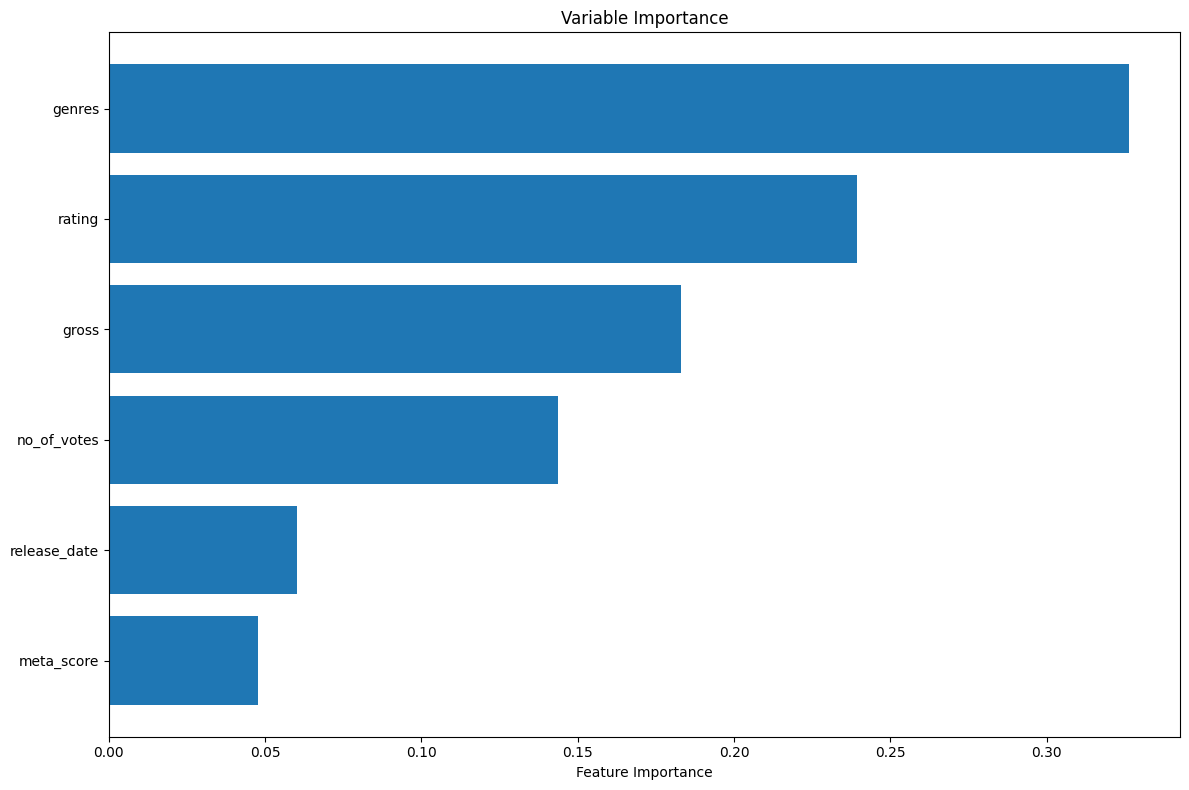


Fold 2
 Best hyperparameters: {'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.5237134006091897
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7527
MAE: 46,958,391.5045
MAPE: 3.09%
Test Metrics
R2 score: 0.5832
MAE: 64,628,264.6972
MAPE: 11.11%


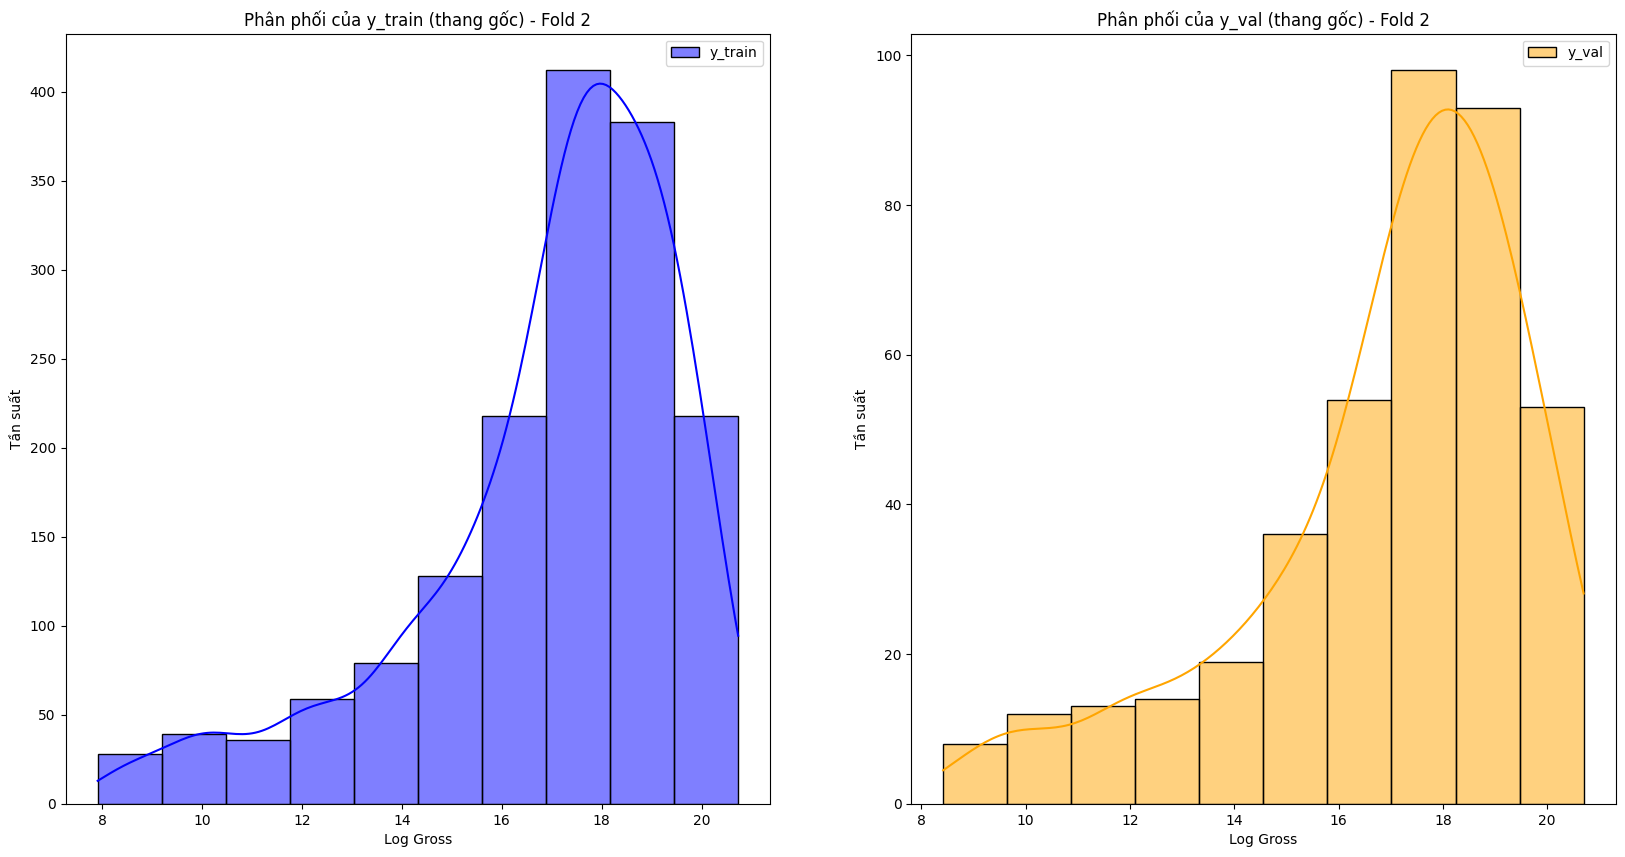

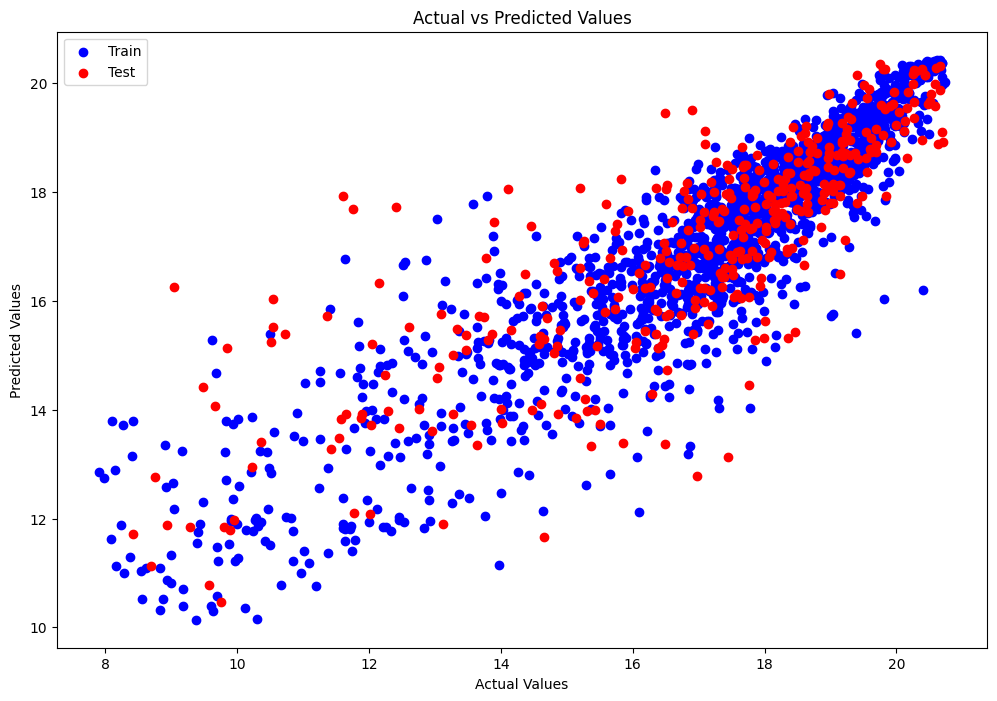

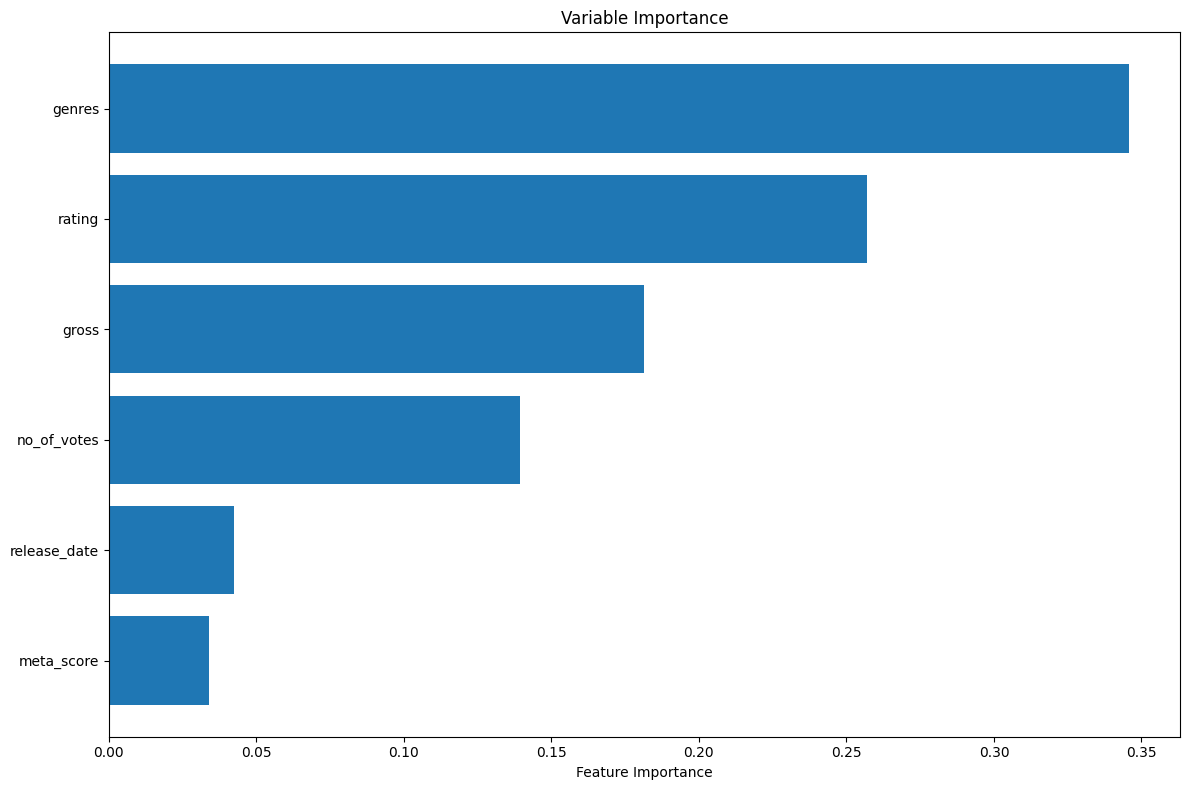


Fold 3
 Best hyperparameters: {'n_estimators': 333, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.360854331495268
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8417
MAE: 34,915,582.1289
MAPE: 1.21%
Test Metrics
R2 score: 0.6925
MAE: 56,747,852.8386
MAPE: 21.20%


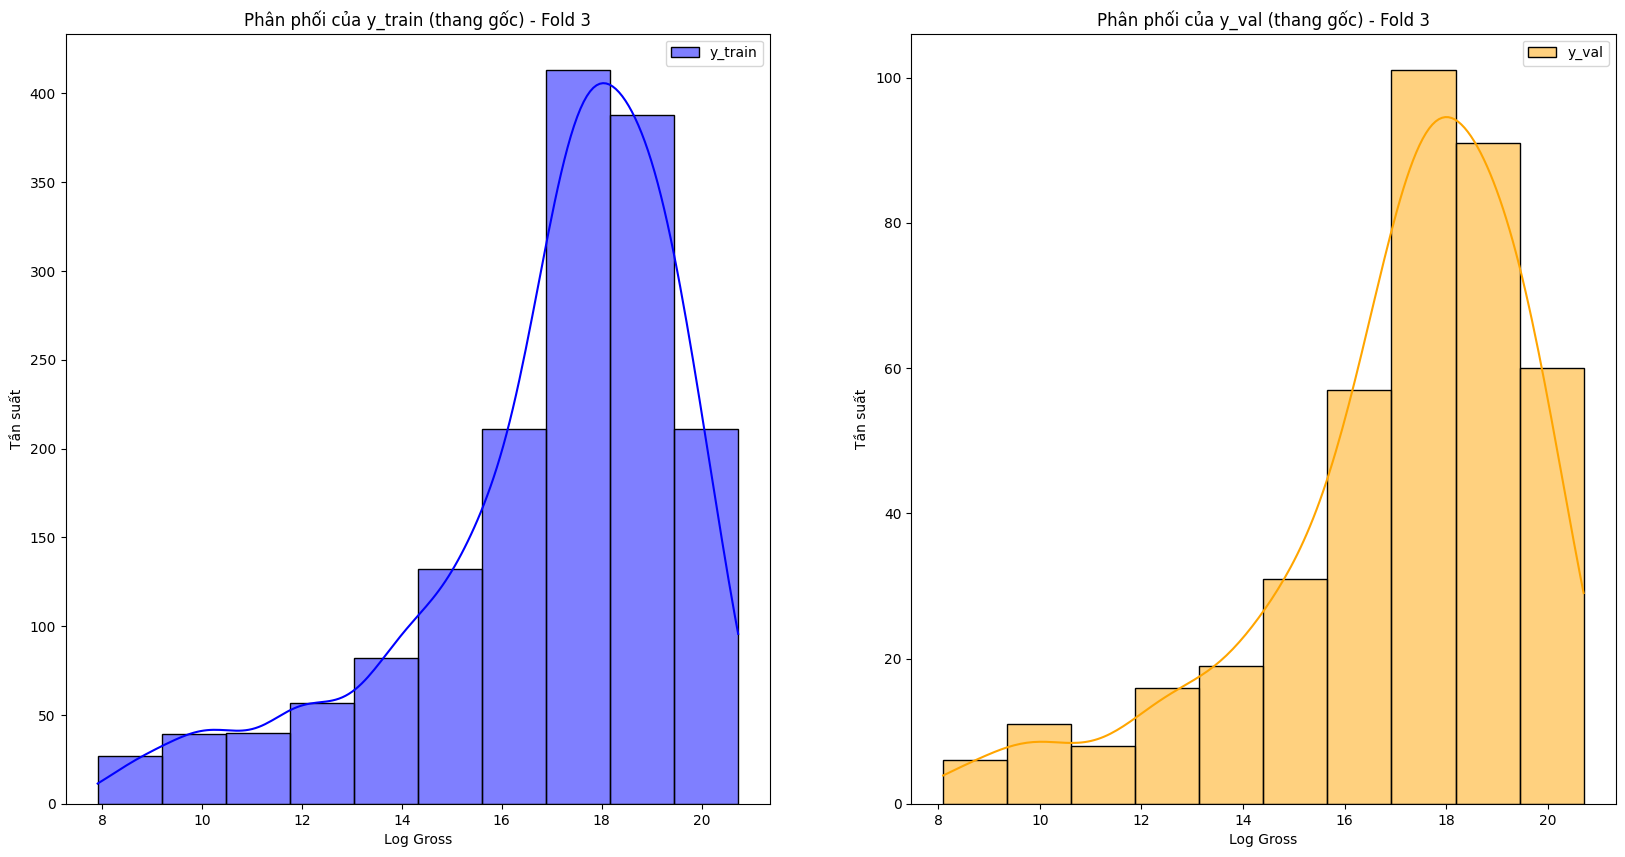

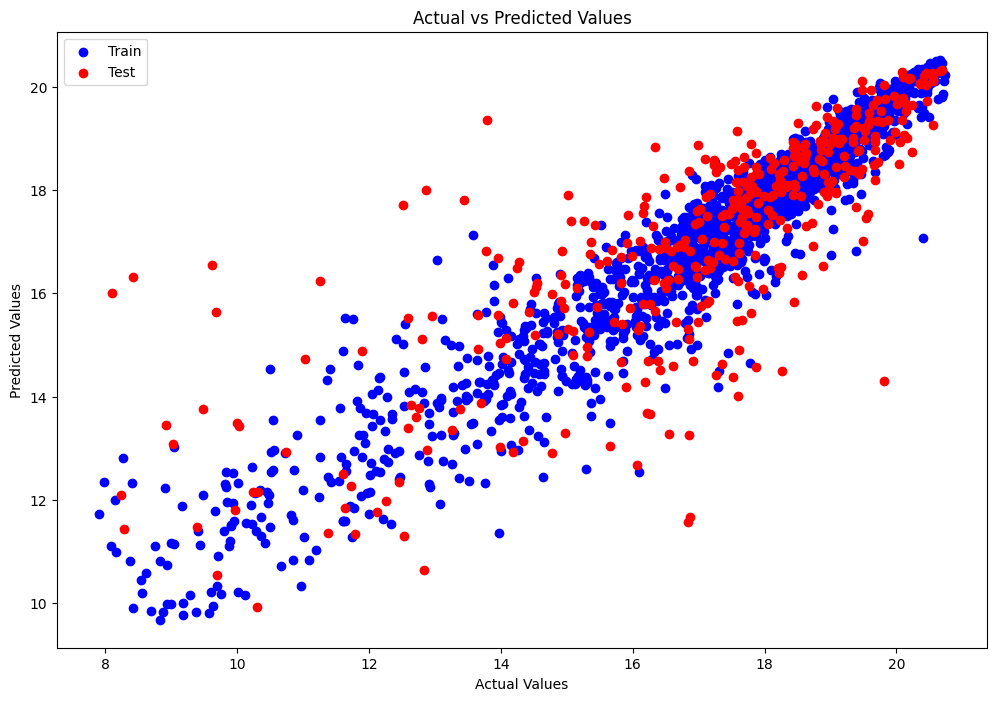

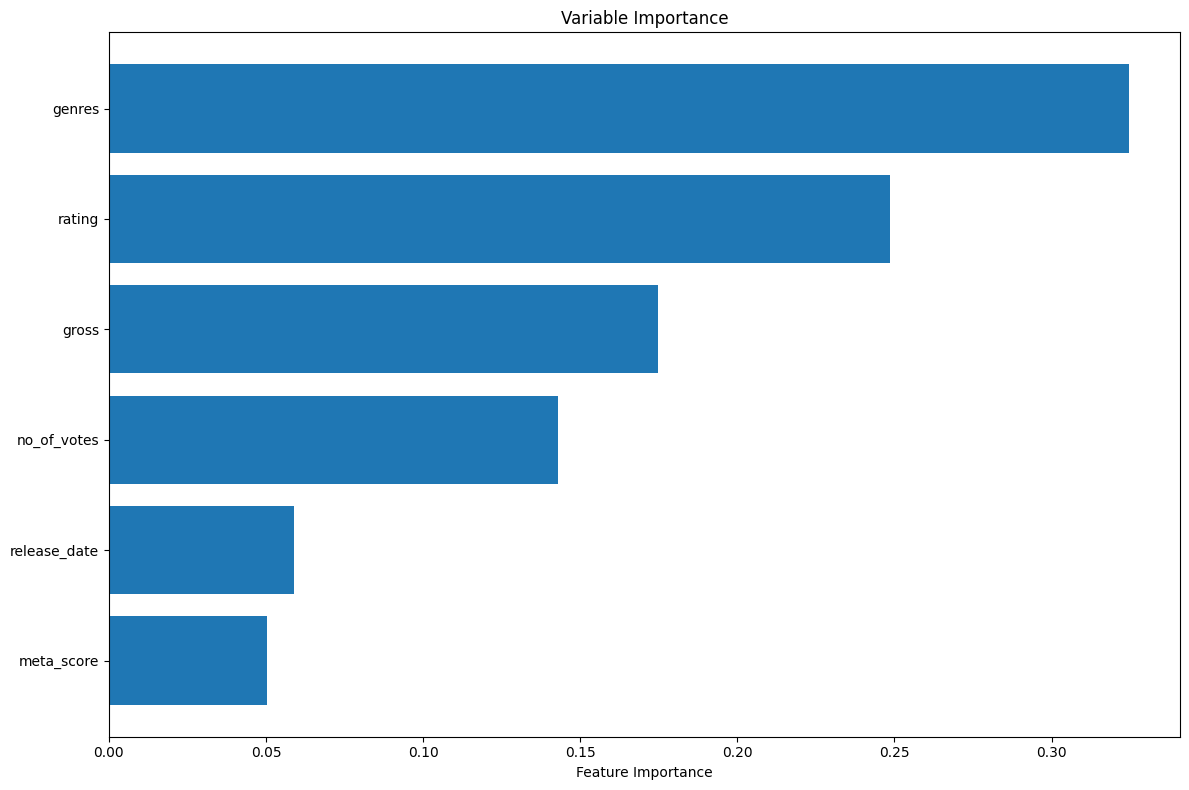


Fold 4
 Best hyperparameters: {'n_estimators': 155, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.545511410428418
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7390
MAE: 47,964,890.3720
MAPE: 3.31%
Test Metrics
R2 score: 0.6011
MAE: 59,701,026.2738
MAPE: 11.15%


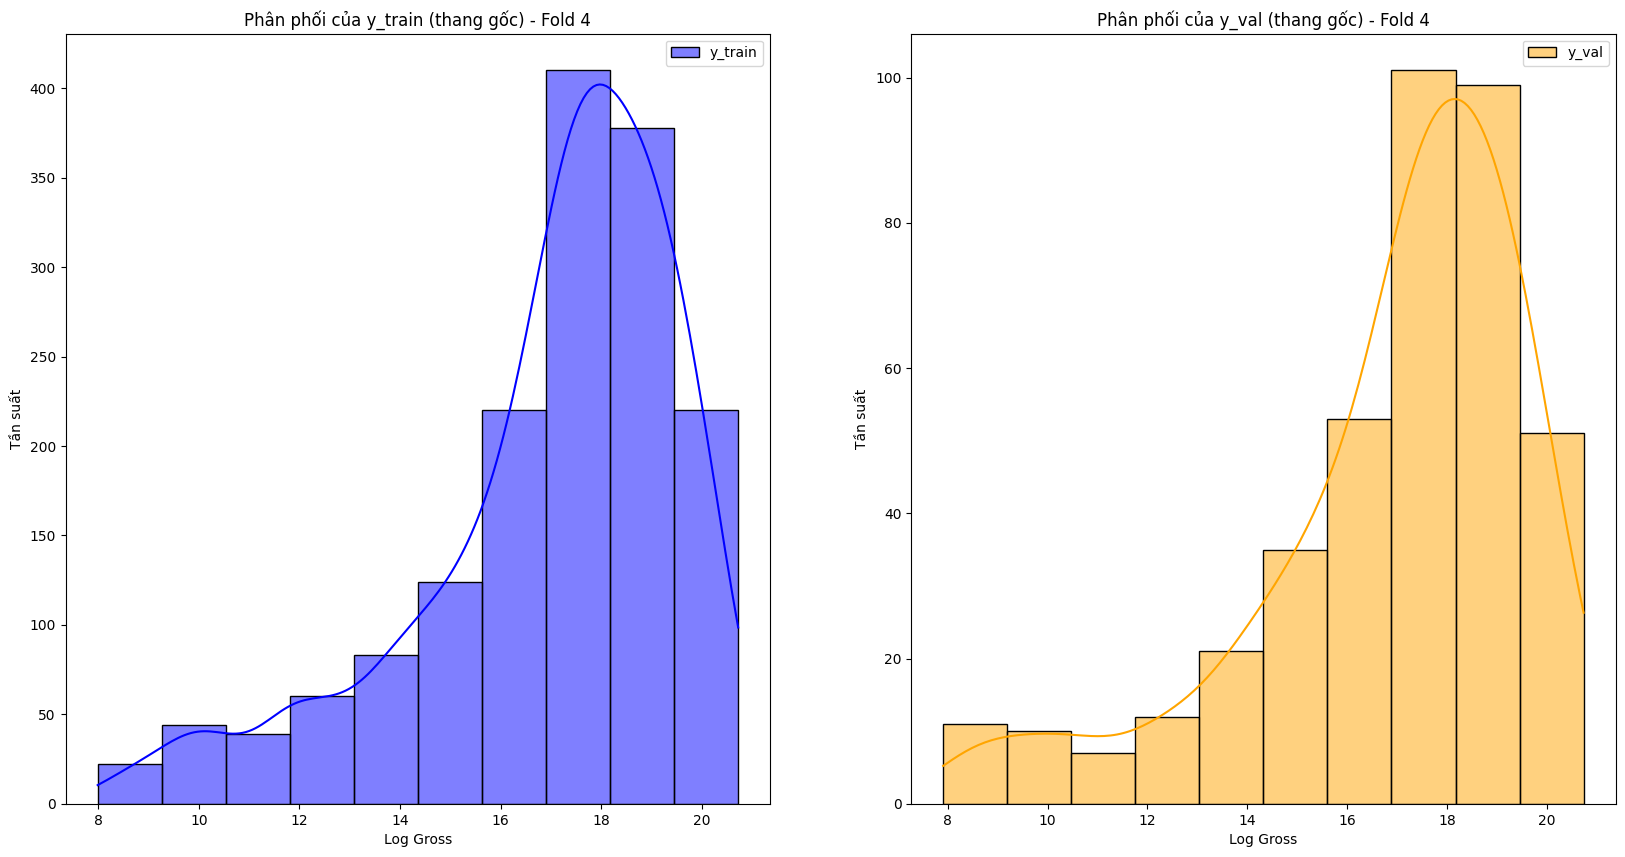

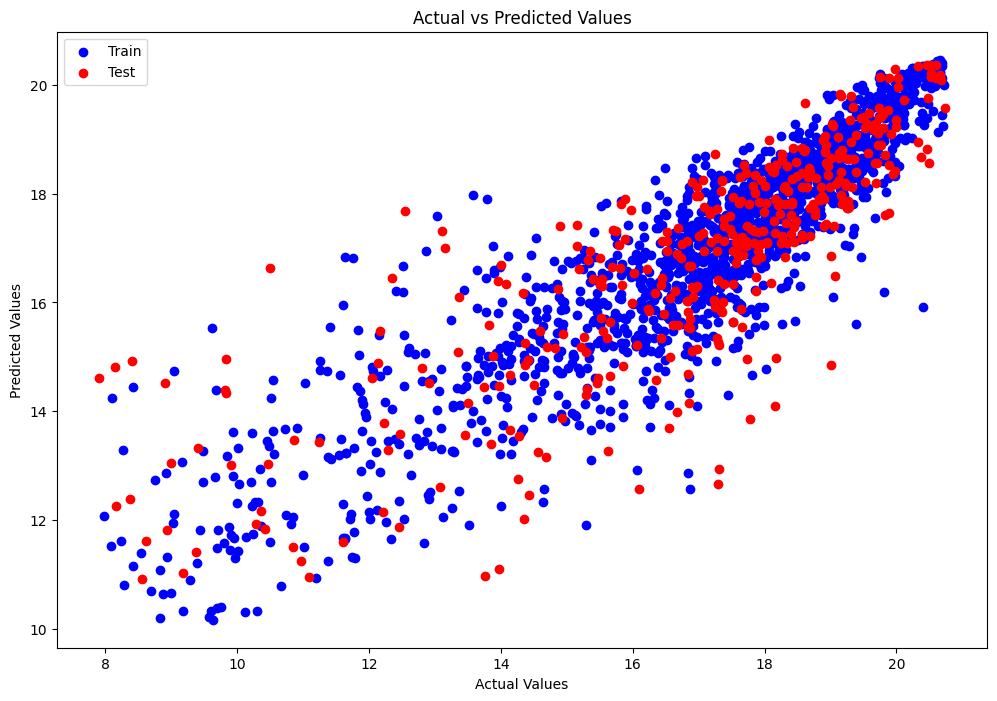

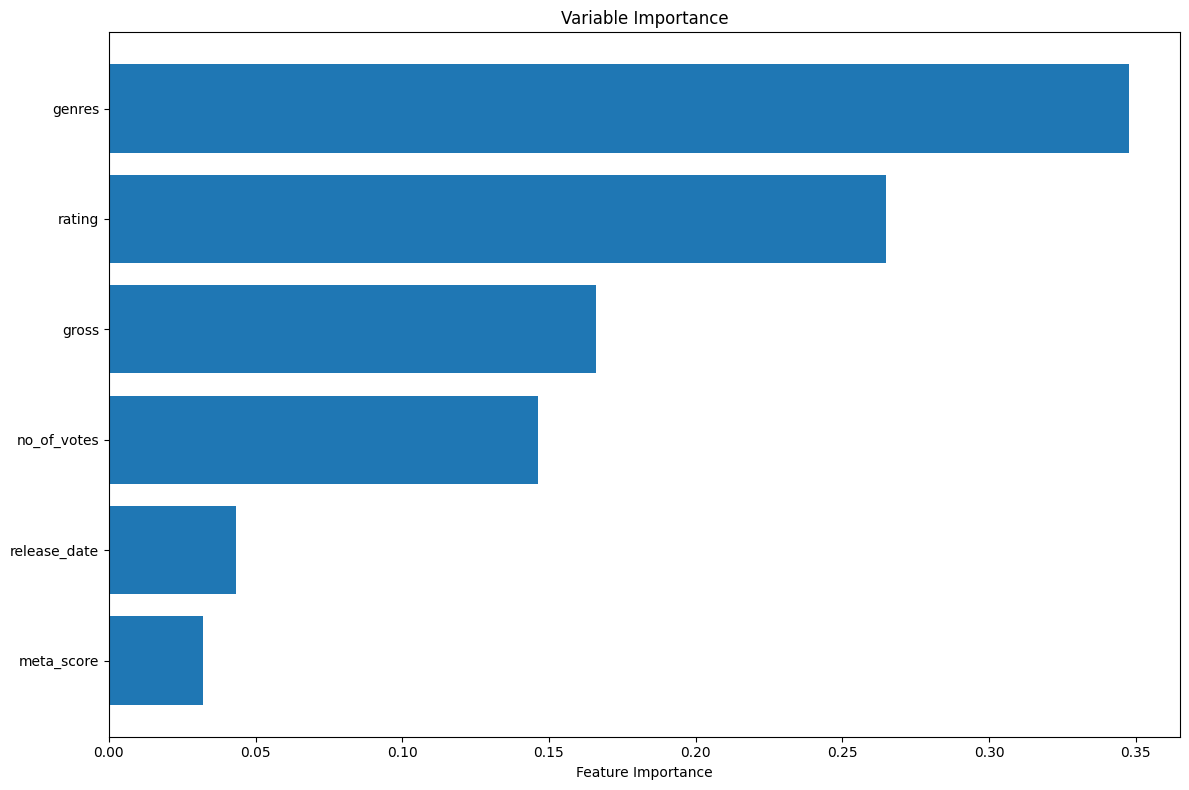


Fold 5
 Best hyperparameters: {'n_estimators': 384, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.6678312704250025
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8423
MAE: 35,440,662.2611
MAPE: 1.47%
Test Metrics
R2 score: 0.6086
MAE: 57,647,693.7211
MAPE: 4.94%


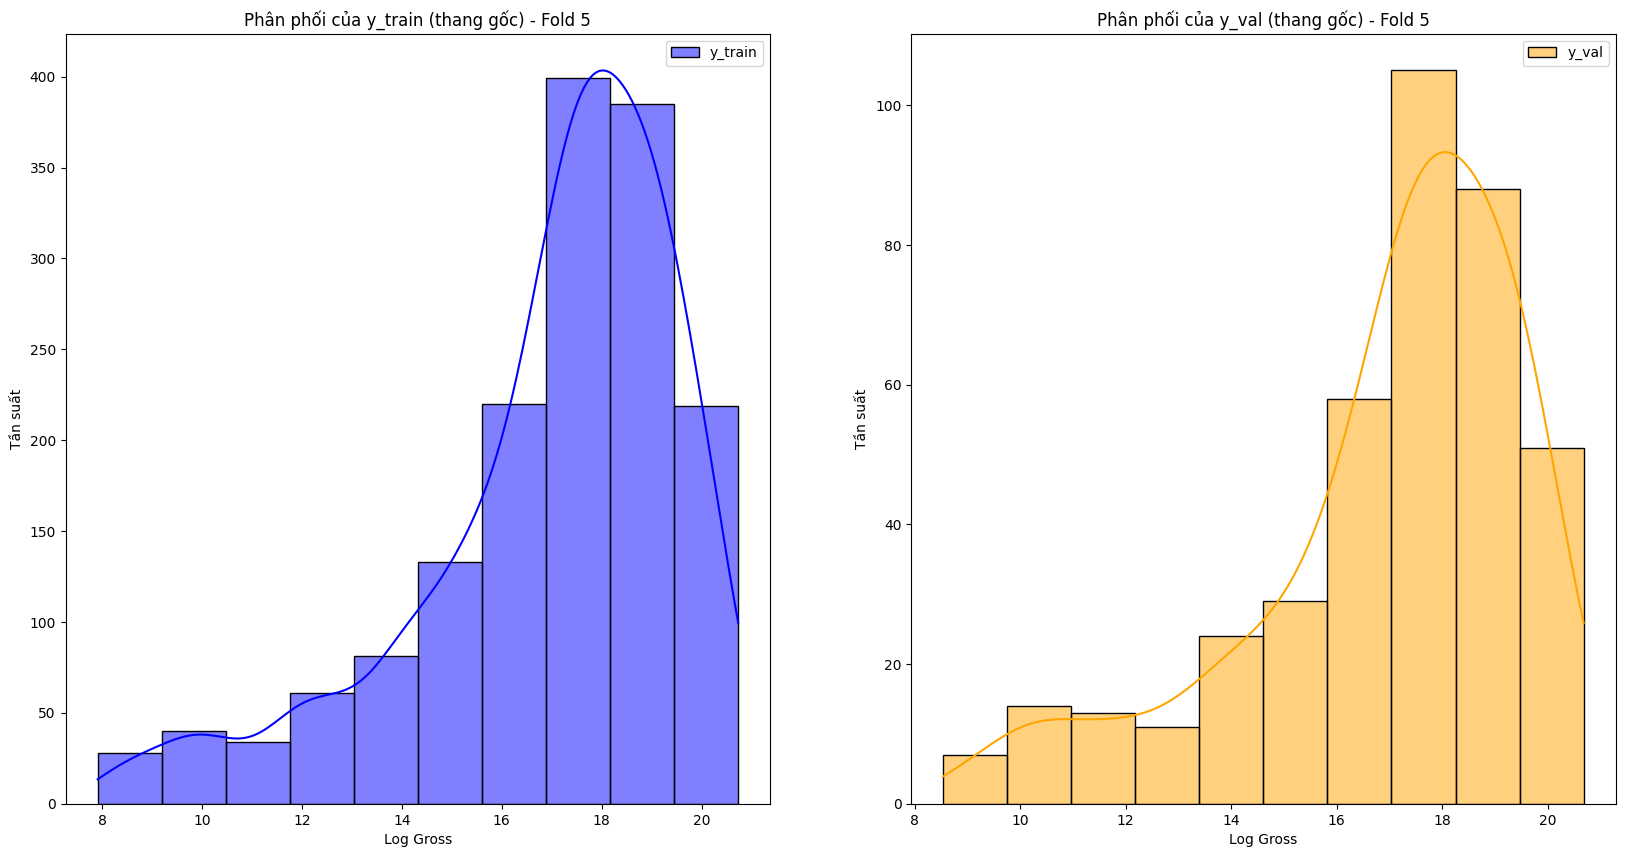

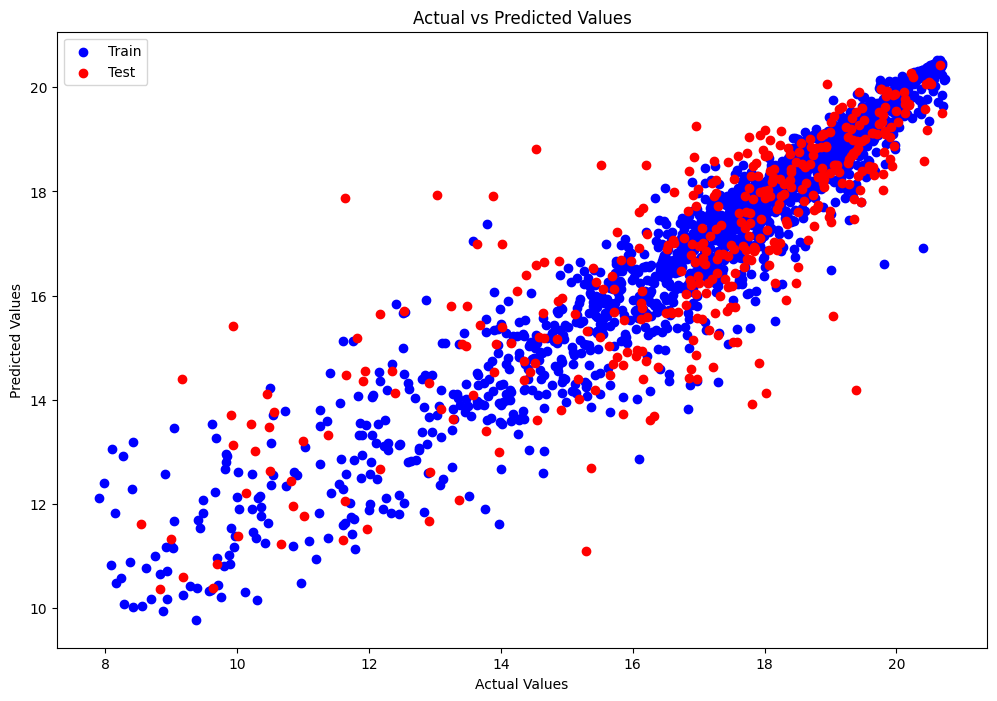

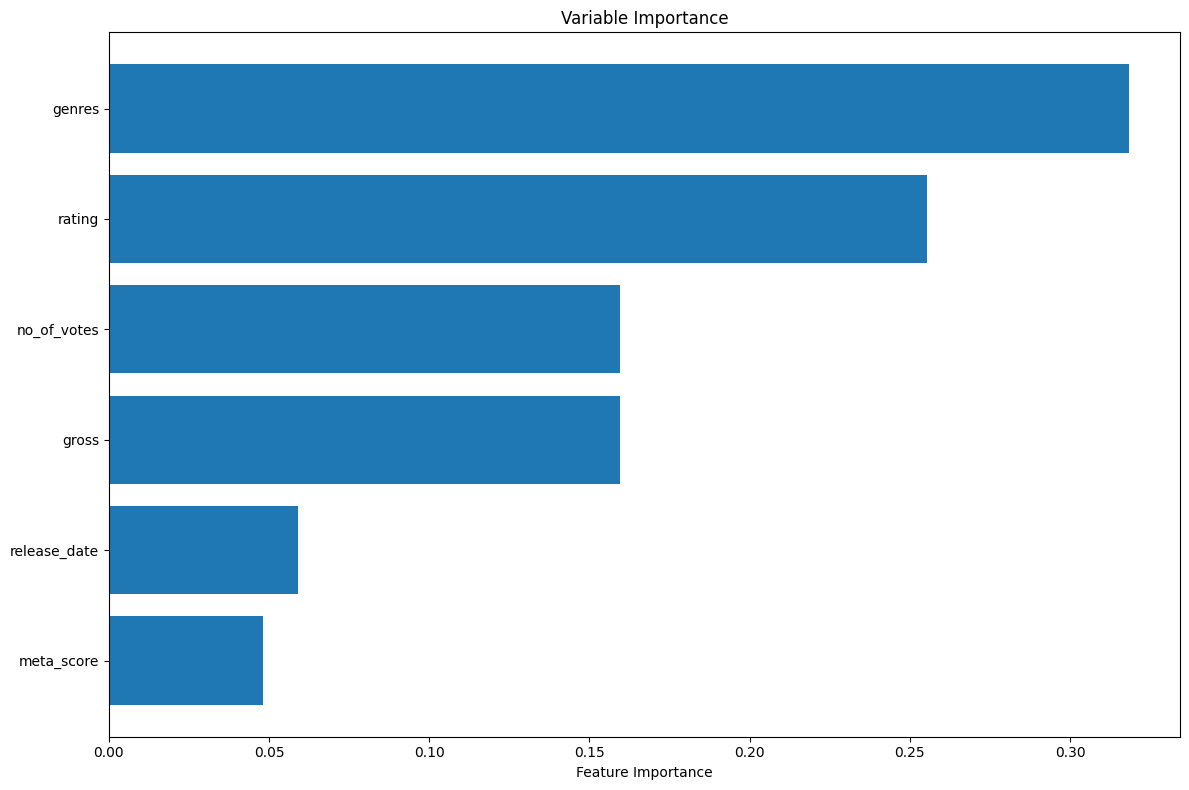

In [4]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from evaluation import visualize_results
import warnings

# warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\nFold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    # Chọn đặc trưng đầu vào và mục tiêu
    #features = ['meta_score', 'rating', 'no_of_votes', 'budget', 'genre_stat_feature', 'country_stat_feature', 'release_date']
    features = ['no_of_votes', 'log_budget',
                'genre_stat_feature','country_stat_feature','rating','release_date']

    target = 'log_gross'

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest",directory="best_models")

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True]),
            'random_state': 42,
            'n_jobs': -1
        }

        model = RandomForestRegressor(**params)
        score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3).mean()
        return -score  # minimize MSE

    #  Tạo study với tên rõ ràng theo từng fold
    study = optuna.create_study(direction="minimize", study_name=f"Fold_{fold+1}_RandomForest")
    study.optimize(objective, n_trials=30)

    print(" Best hyperparameters:", study.best_params)
    print(" Best MSE:", study.best_value)

    best_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    #  Vẽ biểu đồ tối ưu và tầm quan trọng tham số
    print(" Hiển thị quá trình tối ưu:")
    plot_optimization_history(study).show()
    plot_param_importances(study).show()

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )
